### Initial package imports

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Initial files being read in and dataset creation

In [63]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']

#set date as index
main_df = main_df.reset_index(drop=True)

### government bond column

In [64]:
	
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond


# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates




## Portfolio details

### details

#### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

#### Invested amount:
- **10,000,000 EURO**

#### Period:
- **01/01/2012 - 31/12/2021**

#### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

#### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



### weights and currency correction


In [195]:
display(main_df)

Date  S&P500_Closing  Dax40_Closing  Nikkei_Closing  \
0    2012-01-04     1277.300000    6111.550000     8560.110000   
1    2012-01-05     1281.060000    6095.990000     8488.710000   
2    2012-01-06     1277.810000    6057.920000     8390.350000   
3    2012-01-09     1280.700000    6017.230000     8390.350000   
4    2012-01-10     1292.080000    6162.980000     8422.260000   
...         ...             ...            ...             ...   
2800 2022-12-23     3844.820000   13940.930000    26235.250000   
2801 2022-12-27     3829.250000   13995.100000    26447.870000   
2802 2022-12-28     3783.220000   13925.600000    26340.500000   
2803 2022-12-29     3849.280000   14071.720000    26093.670000   
2804 2022-12-30     3839.500000   13923.590000    26094.500000   

      U_S&P500_Returns  U_Dax40_Returns  U_Nikkei_Returns  U_S&P500_Loss  \
0                  NaN              NaN               NaN            NaN   
1             0.002939        -0.002549         -0.008376      -3.760000   
2            -0.002540        -0.006265         -0.011655       3.250000   
3             0.002259        -0.006739          0.000000      -2.890000   
4             0.008847         0.023933          0.003796     -11.380000   
...                ...              ...               ...            ...   
2800          0.005851         0.001929         -0.010338     -22.430000   
2801         -0.004058         0.003878          0.001589      15.570000   
2802         -0.012093        -0.004978         -0.004068      46.030000   
2803          0.017311         0.010438         -0.009415     -66.060000   
2804         -0.002544        -0.010583          0.000032       9.780000   

      U_Dax40_Loss  U_Nikkei_Loss  ...  NIKKEI_Investment  EU_BOND_Investment  \
0              NaN            NaN  ...   148957298.907646      1500000.000000   
1        15.560000      71.400000  ...   148944667.328699      1500246.523142   
2        38.070000      98.360000  ...   148926943.509066      1500493.291886   
3        40.690000       0.000000  ...   148926943.509066      1500738.323863   
4      -145.750000     -31.910000  ...   148932706.981779      1500982.736072   
...            ...            ...  ...                ...                 ...   
2800    -26.860000     272.620000  ...   150353000.311487      1898481.681703   
2801    -54.170000     -42.000000  ...   150354684.265090      1898773.032356   
2802     69.500000     107.370000  ...   150350399.156589      1899065.956342   
2803   -146.120000     246.830000  ...   150340415.890085      1899359.265102   
2804    148.130000      -0.830000  ...   150340450.017359      1899654.703390   

      SP500_Daily_Loss  DAX40_Daily_Loss  NIKKEI_Daily_Loss  \
0             0.000000          0.000000           0.000000   
1        -11903.653074       7647.738000       12631.578947   
2         10363.394286      18746.102438       17723.819633   
3         -9165.573500      20040.577082           0.000000   
4        -35922.849636     -70688.884233       -5763.472714   
...                ...               ...                ...   
2800     -61396.650298     -10754.580279       11021.682812   
2801      42720.075325     -21668.158653       -1683.953604   
2802     127169.794237      27923.358099        4285.108502   
2803    -179135.791591     -58255.637358        9983.266504   
2804      26644.817211      59677.742160         -34.127274   

      EU_BOND_Daily_Loss  Portfolio_Value_EUR  Portfolio_Change_EUR  \
0               0.000000      10000000.000000              0.000000   
1            -246.523142      10058937.403442          58937.403442   
2            -246.768744      10066275.054084           7337.650642   
3            -245.031977      10036177.669230         -30097.384854   
4            -244.412209      10131650.828032          95473.158802   
...                  ...                  ...                   ...   
2800         -288.631268      19071879.609700          61319.287210   
2801   

In [207]:
# initial investment 
weights = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weights['DAX40']
invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weights['EU-BOND']

main_df['corrected_value_SP500'] = main_df['S&P500_Closing'] * main_df['USD/EUR']
main_df['corrected_value_DAX40'] = main_df['Dax40_Closing']
main_df['corrected_value_NIKKEI'] = main_df['Nikkei_Closing'] * main_df['JPY/EUR']


main_df['C_S&P500_Returns'] = main_df['corrected_value_SP500'].pct_change()
main_df['C_Dax40_Returns'] = main_df['corrected_value_DAX40'].pct_change()
main_df['C_Nikkei_Returns'] = main_df['corrected_value_NIKKEI'].pct_change()



invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)
display(main_df['C_S&P500_Returns'])
display(main_df['U_S&P500_Returns'])
display(main_df['USD/EUR'])
display(main_df['corrected_value_SP500'])
display(main_df['S&P500_Closing'])


[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/3638604189.py:30: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  main_df['C_S&P500_Returns'] = main_df['corrected_value_SP500'].pct_change()
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/3638604189.py:32: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  main_df['C_Nikkei_Returns'] = main_df['corrected_value_NIKKEI'].pct_change()


0            NaN
1       0.015407
2       0.002564
3      -0.001308
4       0.007984
          ...   
2800    0.005654
2801   -0.005957
2802   -0.016024
2803    0.000000
2804    0.000000
Name: C_S&P500_Returns, Length: 2805, dtype: float64

0            NaN
1       0.002939
2      -0.002540
3       0.002259
4       0.008847
          ...   
2800    0.005851
2801   -0.004058
2802   -0.012093
2803    0.017311
2804   -0.002544
Name: U_S&P500_Returns, Length: 2805, dtype: float64

0      0.772500
1      0.782100
2      0.786100
3      0.783300
4      0.782600
         ...   
2800   0.939700
2801   0.937900
2802   0.934100
2803        NaN
2804        NaN
Name: USD/EUR, Length: 2805, dtype: float64

0       986.714250
1      1001.917026
2      1004.486441
3      1003.172310
4      1011.181808
           ...    
2800   3612.977354
2801   3591.453575
2802   3533.905802
2803           NaN
2804           NaN
Name: corrected_value_SP500, Length: 2805, dtype: float64

0      1277.300000
1      1281.060000
2      1277.810000
3      1280.700000
4      1292.080000
           ...    
2800   3844.820000
2801   3829.250000
2802   3783.220000
2803   3849.280000
2804   3839.500000
Name: S&P500_Closing, Length: 2805, dtype: float64

### Returns Portfolio 

In [66]:
# Create columns to track investments for each asset
# Initialize the first day with the initial invested amounts
main_df.loc[0, 'SP500_Investment'] = invested_amount_SP500
main_df.loc[0, 'DAX40_Investment'] = invested_amount_DAX40
main_df.loc[0, 'NIKKEI_Investment'] = invested_amount_NIKKEI
main_df.loc[0, 'EU_BOND_Investment'] = invested_amount_EU_BOND

# Calculate daily investment values for subsequent days
# This uses cumulative returns to track the value growth
for i in range(1, len(main_df)):
    # S&P 500 in USD
    main_df.loc[i, 'SP500_Investment'] = main_df.loc[i-1, 'SP500_Investment'] * (1 + main_df.loc[i, 'C_S&P500_Returns'])
    
    # DAX 40 in EUR
    main_df.loc[i, 'DAX40_Investment'] = main_df.loc[i-1, 'DAX40_Investment'] * (1 + main_df.loc[i, 'C_Dax40_Returns'])
    
    # NIKKEI in JPY
    main_df.loc[i, 'NIKKEI_Investment'] = main_df.loc[i-1, 'NIKKEI_Investment'] * (1 + main_df.loc[i, 'C_Nikkei_Returns'])
    
# EU Government Bond value is already calculated in the Interest_Bond column
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']

## Methods input values 

### time window

### Expected returns (daily) --> Action make into method with time window as input parameter

In [67]:
def calculate_expected_daily_returns(time_window, current_date):
    expected_returns = {
        'Date': current_date,
        'SP500_Mean_Return': time_window['C_S&P500_Returns'].mean(),
        'DAX40_Mean_Return': time_window['C_Dax40_Returns'].mean(),
        'NIKKEI_Mean_Return': time_window['C_Nikkei_Returns'].mean(),
        'EU_Bond_Mean_Return': time_window['Interest_Bond_Profit'].mean(),
        'Portfolio_Mean_Return': (
            weights['S&P500'] * time_window['C_S&P500_Returns'].mean() +
            weights['DAX40'] * time_window['C_Dax40_Returns'].mean() +
            weights['NIKKEI'] * time_window['C_Nikkei_Returns'].mean() +
            weights['EU-BOND'] * time_window['Interest_Bond_Profit'].mean()
        )
    }
    return expected_returns

In [68]:
# Create new column in dataframe to store daily loss for each investment
# Calculate daily loss for each investment
# For SP500 (in USD)
main_df.loc[1:, 'SP500_Daily_Loss'] = (
    main_df['SP500_Investment'].shift(1) - main_df['SP500_Investment']
)

# For DAX40 (in EUR)
main_df.loc[1:, 'DAX40_Daily_Loss'] = (
    main_df['DAX40_Investment'].shift(1) - main_df['DAX40_Investment']
)

# For NIKKEI (in JPY)
main_df.loc[1:, 'NIKKEI_Daily_Loss'] = (
    main_df['NIKKEI_Investment'].shift(1) - main_df['NIKKEI_Investment']
)

# For EU Bond (in EUR)
main_df.loc[1:, 'EU_BOND_Daily_Loss'] = (
    main_df['EU_BOND_Investment'].shift(1) - main_df['EU_BOND_Investment']
)

# Set first row losses to 0 since there's no previous day to compare
main_df.loc[0, ['SP500_Daily_Loss', 'DAX40_Daily_Loss', 'NIKKEI_Daily_Loss', 'EU_BOND_Daily_Loss']] = 0


In [69]:
display(main_df)

Date  S&P500_Closing  Dax40_Closing  Nikkei_Closing  \
0    2012-01-04     1277.300000    6111.550000     8560.110000   
1    2012-01-05     1281.060000    6095.990000     8488.710000   
2    2012-01-06     1277.810000    6057.920000     8390.350000   
3    2012-01-09     1280.700000    6017.230000     8390.350000   
4    2012-01-10     1292.080000    6162.980000     8422.260000   
...         ...             ...            ...             ...   
2800 2022-12-23     3844.820000   13940.930000    26235.250000   
2801 2022-12-27     3829.250000   13995.100000    26447.870000   
2802 2022-12-28     3783.220000   13925.600000    26340.500000   
2803 2022-12-29     3849.280000   14071.720000    26093.670000   
2804 2022-12-30     3839.500000   13923.590000    26094.500000   

      U_S&P500_Returns  U_Dax40_Returns  U_Nikkei_Returns  U_S&P500_Loss  \
0                  NaN              NaN               NaN            NaN   
1             0.002939        -0.002549         -0.008376      -3.760000   
2            -0.002540        -0.006265         -0.011655       3.250000   
3             0.002259        -0.006739          0.000000      -2.890000   
4             0.008847         0.023933          0.003796     -11.380000   
...                ...              ...               ...            ...   
2800          0.005851         0.001929         -0.010338     -22.430000   
2801         -0.004058         0.003878          0.001589      15.570000   
2802         -0.012093        -0.004978         -0.004068      46.030000   
2803          0.017311         0.010438         -0.009415     -66.060000   
2804         -0.002544        -0.010583          0.000032       9.780000   

      U_Dax40_Loss  U_Nikkei_Loss  ...  Interest_Bond_Loss  \
0              NaN            NaN  ...            0.000000   
1        15.560000      71.400000  ...         -246.523142   
2        38.070000      98.360000  ...         -246.768744   
3        40.690000       0.000000  ...         -245.031977   
4      -145.750000     -31.910000  ...         -244.412209   
...            ...            ...  ...                 ...   
2800    -26.860000     272.620000  ...         -288.631268   
2801    -54.170000     -42.000000  ...         -291.350653   
2802     69.500000     107.370000  ...         -292.923986   
2803   -146.120000     246.830000  ...         -293.308760   
2804    148.130000      -0.830000  ...         -295.438288   

      Interest_Bond_daily_rate  SP500_Investment  DAX40_Investment  \
0                     0.000164    5177993.527508    3000000.000000   
1                     0.000164    5189897.180583    2992352.262000   
2                     0.000164    5179533.786296    2973606.159562   
3                     0.000163    5188699.359796    2953565.582481   
4                     0.000163    5224622.209432    3024254.466714   
...                        ...               ...               ...   
2800                  0.000152   11203387.897754    5587239.551284   
2801                  0.000153   11160667.822429    5608907.709937   
2802                  0.000154   11033498.028193    5580984.351838   
2803                  0.000154   11212633.819784    5639239.989196   
2804                  0.000156   11185989.002573    5579562.247036   

      NIKKEI_Investment  EU_BOND_Investment  SP500_Daily_Loss  \
0      148957298.907646      1500000.000000          0.000000   
1      148944667.328699      1500246.523142     -11903.653074   
2      148926943.509066      1500493.291886      10363.394286   
3      148926943.509066      1500738.323863      -9165.573500   
4      148932706.981779      1500982.736072     -35922.849636   
...                 ...                 ...               ...   
2800   150353000.311487      1898481.681703     -61396.650298   
2801   150354684.265090      1898773.032356      42720.075325   
2802   150350399.156589      1899065.956342     127169.794237   
2803   150340415.890085      1899359.265102    -179135.791591   
2804

In [70]:
# Calculate total portfolio value in EUR for each day
main_df['Portfolio_Value_EUR'] = (
    main_df['SP500_Investment'].fillna(0) * main_df['USD/EUR'] +
    main_df['DAX40_Investment'].fillna(0) +
    main_df['NIKKEI_Investment'].fillna(0) * main_df['JPY/EUR'] +
    main_df['EU_BOND_Investment'].fillna(0)
)

# First day should be the initial investment amount
main_df.loc[0, 'Portfolio_Value_EUR'] = starting_investment

# Calculate the daily change in portfolio value (profit/loss)
main_df['Portfolio_Change_EUR'] = main_df['Portfolio_Value_EUR'].diff()
main_df.loc[0, 'Portfolio_Change_EUR'] = 0.0  # Set the first day's change to 0

# Portfolio loss is the negative of the daily change
main_df['Portfolio_loss'] = -main_df['Portfolio_Change_EUR']

# Set the first day's loss to 0 (there's no previous day to compare with)
main_df.loc[0, 'Portfolio_loss'] = 0.0

# Display the relevant columns to verify
display(main_df[['Date', 'SP500_Investment', 'DAX40_Investment', 'NIKKEI_Investment', 
                'EU_BOND_Investment', 'USD/EUR', 'JPY/EUR', 'Portfolio_Value_EUR', 
                'Portfolio_Change_EUR', 'Portfolio_loss']].head())

Date  SP500_Investment  DAX40_Investment  NIKKEI_Investment  \
0 2012-01-04    5177993.527508    3000000.000000   148957298.907646   
1 2012-01-05    5189897.180583    2992352.262000   148944667.328699   
2 2012-01-06    5179533.786296    2973606.159562   148926943.509066   
3 2012-01-09    5188699.359796    2953565.582481   148926943.509066   
4 2012-01-10    5224622.209432    3024254.466714   148932706.981779   

   EU_BOND_Investment  USD/EUR  JPY/EUR  Portfolio_Value_EUR  \
0      1500000.000000 0.772500 0.010070      10000000.000000   
1      1500246.523142 0.782100 0.010120      10058937.403442   
2      1500493.291886 0.786100 0.010210      10066275.054084   
3      1500738.323863 0.783300 0.010190      10036177.669230   
4      1500982.736072 0.782600 0.010190      10131650.828032   

   Portfolio_Change_EUR  Portfolio_loss  
0              0.000000        0.000000  
1          58937.403442   -58937.403442  
2           7337.650642    -7337.650642  
3         -30097.384854    30097.384854  
4          95473.158802   -95473.158802

In [71]:
loss_values = main_df['Portfolio_loss'].values

# Calculate and print the minimum, maximum, and mean of portfolio loss values
min_loss = np.nanmin(loss_values)
max_loss = np.nanmax(loss_values)
mean_loss = np.nanmean(loss_values)

print(f"Portfolio Loss Statistics:")
print(f"Minimum Loss: {min_loss:.4f}")
print(f"Maximum Loss: {max_loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")

# Also print the number of valid loss values (non-NaN)
valid_count = np.sum(~np.isnan(loss_values))
print(f"Number of valid loss values: {valid_count} out of {len(loss_values)}")

Portfolio Loss Statistics:
Minimum Loss: -850226.1277
Maximum Loss: 1342732.3566
Mean Loss: -3159.9667
Number of valid loss values: 2803 out of 2805


In [72]:
def calculate_daily_loss_variables(time_window, current_date):
    # Calculate the mean and standard deviation of portfolio loss from the time windows
    loss_dict = {
        "Date": current_date,
        "Portfolio_mean_loss": np.nanmean(time_window['Portfolio_loss']),
        "Portfolio_std_loss": np.nanstd(time_window['Portfolio_loss'])
    }
    return loss_dict

### Covariance matrix --> action make into method with variable time window

### Portfolio variance & standard deviation

In [73]:
def calculate_variance_return(window, current_date, weights):
    """
    Calculate the variance returns for each index and the portfolio variance and volatility.
    """
    variance_return = {
        'Date': current_date,
        'SP500_Var_Return': window['C_S&P500_Returns'].var(),
        'DAX40_Var_Return': window['C_Dax40_Returns'].var(),
        'NIKKEI_Var_Return': window['C_Nikkei_Returns'].var(),
        'EU_Bond_Var_Return': window['Interest_Bond_daily_rate'].var()
    }

    weights = np.array([weights['S&P500'], weights['DAX40'], weights['NIKKEI'], weights['EU-BOND']])

    # Calculate the covariance matrix for the returns in the window
    covariance_matrix = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].cov()

    # Calculate the portfolio variance using the covariance matrix and weights
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix.values, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)

    # Add portfolio variance and volatility to the variance_return dictionary
    variance_return['Portfolio_Variance'] = portfolio_variance
    variance_return['Portfolio_Volatility'] = portfolio_volatility

    return variance_return

# Value at Risk (VaR)

In [74]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dVaR = r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)

        c = s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0
    return dVaR

# Expected Shortfall (ES) 

In [75]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0
    return dES

## performing different methods

write method for variance covariance where the sample period is an input parameter alongside other parameters that are needed for the calculation

## 1. var/cov multivar normal dist & T-distribution

4 code blocks with functions to calculate components of Var/cov method, 1 code block with for loop to iterate through set window for daily VaR and ES

## Main method

In [76]:
def main():
    # Initialize lists to store results
    mean_losses = []
    portfolio_std_losses = [] # Store standard dev of losses
    VaR_results = []
    ES_results = []  # List to store ES results
    time_window = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]

    vAlpha= [.95, .99]
    vAlpha= np.array(vAlpha)

    # Iterate through the DataFrame with a rolling window of 500 days
    sample_size = 500
    degrees_of_freedom = [0, 3, 4, 5, 6] # Normal (0) and T-distributions

    for i in range(sample_size, len(time_window)):
        # Extract the window of 500 days
        window = time_window.iloc[i - sample_size:i]
        current_date = time_window.iloc[i]['Date']
        
        # Calculate mean loss and portfolio std dev of LOSS
        loss_stats = calculate_daily_loss_variables(window, current_date)
        mean_loss = loss_stats["Portfolio_mean_loss"]
        portfolio_std_loss = loss_stats["Portfolio_std_loss"] # Use std dev of loss
        
        # Append the results to the lists
        mean_losses.append(mean_loss)
        portfolio_std_losses.append(portfolio_std_loss)
        
        # Dictionaries to hold results for the current date
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}
        
        # Calculate VaR and ES for each degree of freedom using mean and std dev of LOSS
        for df in degrees_of_freedom:
            # Use portfolio_std_loss (std dev of loss) as 's' parameter
            current_var = VaR(vAlpha, mean_loss, portfolio_std_loss, df)
            current_es = ES(vAlpha, mean_loss, portfolio_std_loss, df)
            
            # Determine the key name (e.g., 'VaR Normal', 'VaR T3')
            var_key = f"VaR {'Normal' if df == 0 else f'T{df}'}"
            es_key = f"ES {'Normal' if df == 0 else f'T{df}'}"
            
            # Add to the row dictionaries
            var_row[var_key] = current_var
            es_row[es_key] = current_es

        # Historical simulation
        # Extract the portfolio loss values from the window
        historical_losses = window['Portfolio_loss'].dropna()  # Remove NaN values directly
        
        # Sort the losses in ascending order
        sorted_losses = np.sort(historical_losses)

        # Calculate VaR for alpha levels
        var_95 = np.percentile(sorted_losses, 95) 
        var_99 = np.percentile(sorted_losses, 99)  

        # Calculate ES
        es_95 = sorted_losses[sorted_losses >= var_95].mean()  # Mean of losses below VaR 95
        es_99 = sorted_losses[sorted_losses >= var_99].mean()  # Mean of losses below VaR 99

        # Add to the row dictionaries
        var_row['VaR Historical'] = [var_95, var_99]
        es_row['ES Historical'] = [es_95, es_99]
        
        # Append the dictionaries to the results lists
        VaR_results.append(var_row)
        ES_results.append(es_row)

    # Convert the results to DataFrames for easier analysis
    mean_losses_df = pd.DataFrame(mean_losses, columns=['Mean_Loss'])
    portfolio_std_losses_df = pd.DataFrame(portfolio_std_losses, columns=['Portfolio_Std_Loss']) # New DataFrame for std dev of loss
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)

    # Return all relevant DataFrames
    return mean_losses_df, portfolio_std_losses_df, var_results_df, es_results_df

In [77]:
mean_losss_df, portfolio_std_losses_df, var_results_df, es_results_df = main()

print("mean_loss")
display(mean_losss_df.head())
print("portfolio_std_losses")
display(portfolio_std_losses_df.head())
print("VaR results")
display(var_results_df.head())
print("ES results")
display(es_results_df.head())

mean_loss


Mean_Loss
0 -3885.414580
1 -3789.230116
2 -3921.528773
3 -4071.347661
4 -4223.641629

portfolio_std_losses


Portfolio_Std_Loss
0        51680.313057
1        51732.182101
2        51957.142800
3        52074.645375
4        52085.841072

VaR results


Date                               VaR Normal  \
0 2013-12-17  [81121.13579380632, 116340.97183010408]   
1 2013-12-18   [81302.6372423799, 116557.82173332498]   
2 2013-12-19   [81540.36600705239, 116948.8599203884]   
3 2013-12-20  [81583.82165663295, 117072.39289918296]   
4 2013-12-23  [81449.94297045413, 116946.14401575756]   

                                    VaR T3  \
0  [66333.40262551841, 131598.45471506348]   
1  [66500.06233789831, 131830.61781966424]   
2   [66673.42115978729, 132288.0707363653]   
3  [66683.25478523277, 132446.29378239065]   
4   [66546.17257797201, 132323.3501836578]   

                                    VaR T4  \
0  [74019.72806480108, 133041.15660520023]   
1  [74194.10217215758, 133274.76768026515]   
2  [74400.91901787695, 133738.50057490906]   
3   [74428.22860238179, 133900.0038098057]   
4  [74292.81151210057, 133777.37274889508]   

                                    VaR T5  \
0  [76779.78956616337, 130817.43865770628]   
1   [76956.93381443433, 131048.8178940729]   
2  [77175.76501008144, 131502.87110384437]   
3  [77209.34998874959, 131659.31839827672]   
4   [77074.53082075343, 131536.2056051598]   

                                    VaR T6  \
0  [78110.57296727752, 128725.13208200427]   
1  [78289.05285881074, 128954.41137094288]   
2  [78513.67685923813, 129399.35692012627]   
3  [78550.28756410257, 129551.04705662336]   
4  [78415.75668861429, 129427.48099942949]   

                           VaR Historical  
0  [76635.87745611469, 124145.5344469194]  
1  [76635.87745611469, 124145.5344469194]  
2  [76635.87745611469, 124145.5344469194]  
3  [76635.87745611469, 124145.5344469194]  
4  [76635.87745611469, 124145.5344469194]

ES results


Date                                 ES Normal  \
0 2013-12-17   [102716.22905878669, 133853.6906917133]   
1 2013-12-18  [102919.40446331211, 134088.11726814165]   
2 2013-12-19   [103251.1351214494, 134555.38706543748]   
3 2013-12-20  [103343.69030093706, 134718.73771266945]   
4 2013-12-23   [103214.48983932134, 134596.2826740096]   

                                      ES T3  \
0   [111713.59516476547, 205070.0447112846]   
1   [111925.80079269724, 205375.9477153037]   
2  [112296.69634073708, 206153.21719823903]   
3  [112409.70831755296, 206478.48840127286]   
4  [112282.45698848339, 206371.46122358963]   

                                      ES T4  \
0   [113158.67937123317, 186893.0029734859]   
1    [113372.33536064536, 187180.662555394]   
2  [113749.52125668032, 187878.80867822265]   
3  [113865.81883890402, 188162.75177984586]   
4  [113738.88056374664, 188051.78684268647]   

                                      ES T5  \
0  [111810.48857819285, 174351.54886223737]   
1  [112022.79145338114, 174626.62119015015]   
2    [112394.1087715062, 175270.1752619609]   
3    [112507.341049341, 175525.60357581917]   
4  [112380.11071064833, 175411.92173728035]   

                                      ES T6  \
0   [110499.07540278639, 166274.3450210635]   
1   [110710.06207567587, 166541.3106481568]   
2   [111075.67090622506, 167149.7052304643]   
3  [111185.92149883923, 167386.76886737032]   
4    [111058.407063882, 167271.33723442463]   

                             ES Historical  
0  [111708.34702453166, 164482.1976745602]  
1  [111708.34702453166, 164482.1976745602]  
2  [111708.34702453166, 164482.1976745602]  
3  [111708.34702453166, 164482.1976745602]  
4  [111708.34702453166, 164482.1976745602]

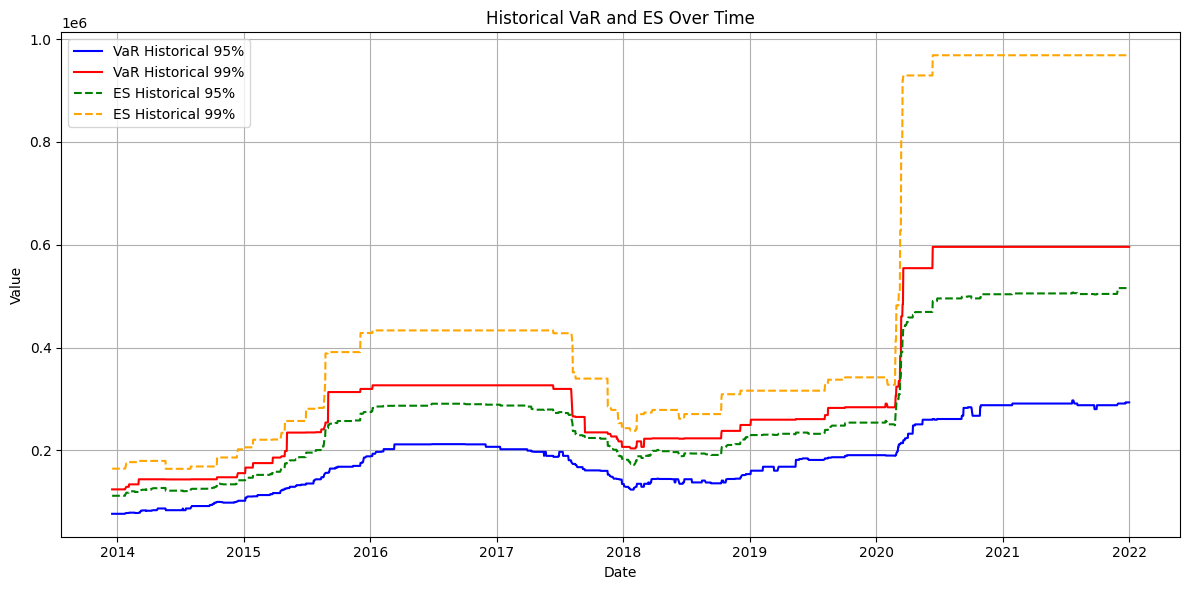

In [78]:
# Plot Historical VaR and ES over time
plt.figure(figsize=(12, 6))

# Extract the values for different confidence levels from the arrays
var_95 = [row[0] for row in var_results_df['VaR Historical']]
var_99 = [row[1] for row in var_results_df['VaR Historical']]
es_95 = [row[0] for row in es_results_df['ES Historical']]
es_99 = [row[1] for row in es_results_df['ES Historical']]

# Plot VaR Historical 95% and 99%
plt.plot(var_results_df['Date'], var_95, label='VaR Historical 95%', color='blue')
plt.plot(var_results_df['Date'], var_99, label='VaR Historical 99%', color='red')

# Plot ES Historical 95% and 99%
plt.plot(es_results_df['Date'], es_95, label='ES Historical 95%', color='green', linestyle='--')
plt.plot(es_results_df['Date'], es_99, label='ES Historical 99%', color='orange', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Historical VaR and ES Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

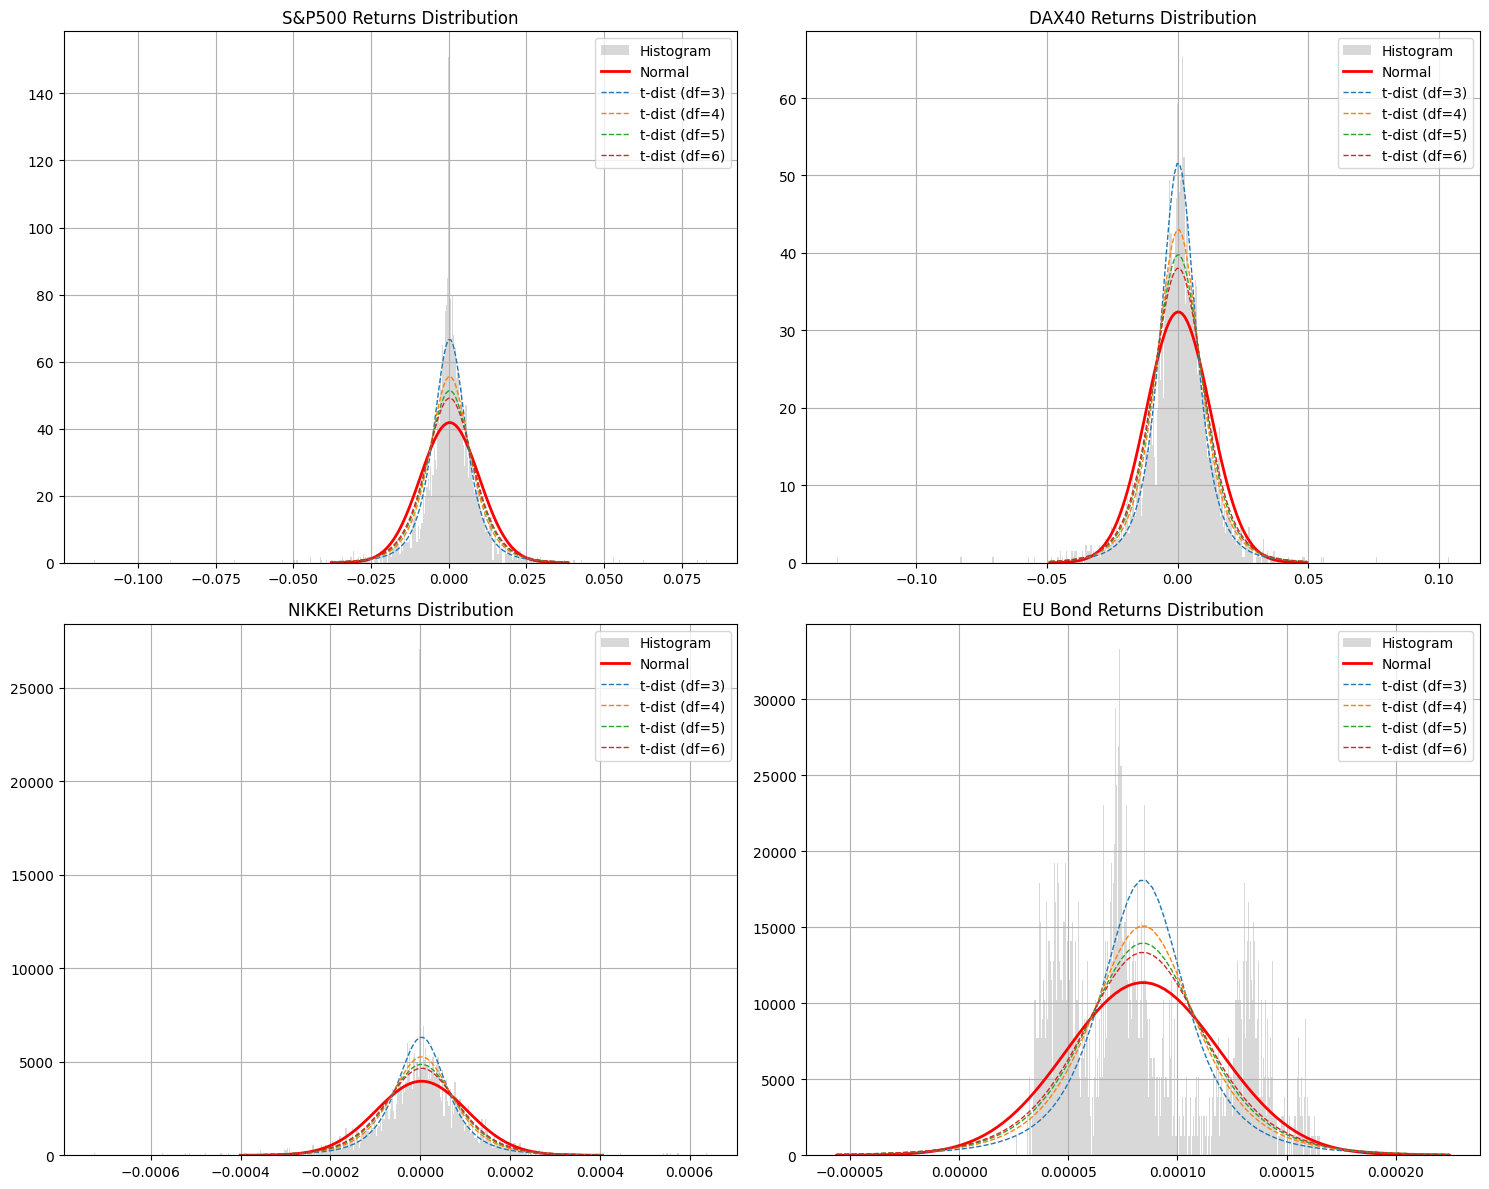

In [79]:
# Create subplots for all indices
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# S&P 500
sp500_returns = main_df['C_S&P500_Returns'].dropna()
mu_sp500 = sp500_returns.mean()
sigma_sp500 = sp500_returns.std()
x_sp500 = np.linspace(mu_sp500 - 4*sigma_sp500, mu_sp500 + 4*sigma_sp500, 100)
ax1.hist(sp500_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax1.plot(x_sp500, st.norm.pdf(x_sp500, mu_sp500, sigma_sp500), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_sp500 / np.sqrt(df/(df-2))
    ax1.plot(x_sp500, st.t.pdf((x_sp500-mu_sp500)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax1.set_title('S&P500 Returns Distribution')
ax1.legend()
ax1.grid(True)

# DAX40
dax_returns = main_df['C_Dax40_Returns'].dropna()
mu_dax = dax_returns.mean()
sigma_dax = dax_returns.std()
x_dax = np.linspace(mu_dax - 4*sigma_dax, mu_dax + 4*sigma_dax, 100)
ax2.hist(dax_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax2.plot(x_dax, st.norm.pdf(x_dax, mu_dax, sigma_dax), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_dax / np.sqrt(df/(df-2))
    ax2.plot(x_dax, st.t.pdf((x_dax-mu_dax)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax2.set_title('DAX40 Returns Distribution')
ax2.legend()
ax2.grid(True)

# NIKKEI
nikkei_returns = main_df['C_Nikkei_Returns'].dropna()
mu_nikkei = nikkei_returns.mean()
sigma_nikkei = nikkei_returns.std()
x_nikkei = np.linspace(mu_nikkei - 4*sigma_nikkei, mu_nikkei + 4*sigma_nikkei, 100)
ax3.hist(nikkei_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax3.plot(x_nikkei, st.norm.pdf(x_nikkei, mu_nikkei, sigma_nikkei), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_nikkei / np.sqrt(df/(df-2))
    ax3.plot(x_nikkei, st.t.pdf((x_nikkei-mu_nikkei)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax3.set_title('NIKKEI Returns Distribution')
ax3.legend()
ax3.grid(True)

# EU Bond
bond_returns = main_df['Interest_Bond_daily_rate'].dropna()
mu_bond = bond_returns.mean()
sigma_bond = bond_returns.std()
x_bond = np.linspace(mu_bond - 4*sigma_bond, mu_bond + 4*sigma_bond, 100)
ax4.hist(bond_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax4.plot(x_bond, st.norm.pdf(x_bond, mu_bond, sigma_bond), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_bond / np.sqrt(df/(df-2))
    ax4.plot(x_bond, st.t.pdf((x_bond-mu_bond)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax4.set_title('EU Bond Returns Distribution')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

## GARCH(1,1) with constant conditional correlation 

## EWMA

In [217]:
from typing import Dict, List, Union

def compute_ewma_volatility(
    returns: pd.DataFrame, 
    lambdas: List[float] = [0.94, 0.97]
) -> Dict[str, pd.DataFrame]:
    """
    Compute EWMA volatility for each risk factor using different lambda values.

    Parameters:
    ----------
    returns : pd.DataFrame
        DataFrame of returns (T x N), excluding Date column
    lambdas : List[float], optional
        List of smoothing factors, by default [0.94, 0.97]

    Returns:
    -------
    Dict[str, pd.DataFrame]
        Dictionary of DataFrames containing EWMA volatilities for each lambda
    """
    # Input validation
    if not isinstance(returns, pd.DataFrame):
        raise TypeError("returns must be a pandas DataFrame")
    
    # Remove Date column if present
    if 'Date' in returns.columns:
        returns = returns.drop('Date', axis=1)
    
    results = {}
    
    for lambda_ in lambdas:
        n_obs, n_assets = returns.shape
        ewma_vol = np.zeros((n_obs, n_assets))
        
        # Initialize first value with sample standard deviation
        ewma_vol[0] = returns.std().values  # per-asset std dev as initial values

        
        # Loop through time to apply EWMA formula
        for t in range(1, n_obs):
            ewma_vol[t] = np.sqrt(
                lambda_ * ewma_vol[t-1]**2 + 
                (1 - lambda_) * returns.iloc[t-1].values**2
            )
        
        # Store results in dictionary
        results[f'lambda_{lambda_}'] = pd.DataFrame(
            ewma_vol,
            index=returns.index,
            columns=returns.columns
        )
    
    return results

# Example usage
returns_df = main_df[['Date', 'C_S&P500_Returns', 'C_Dax40_Returns', 
                      'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()
#set Date as index
returns_df.set_index('Date', inplace=True)
ewma_results = compute_ewma_volatility(returns_df)
print(ewma_results)

{'lambda_0.94':             C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
Date                                                              
2012-01-05          0.011899         0.012287          0.013076   
2012-01-06          0.012138         0.011929          0.012705   
2012-01-09          0.011785         0.011666          0.012337   
2012-01-10          0.011430         0.011430          0.011971   
2012-01-11          0.011253         0.012570          0.011644   
...                      ...              ...               ...   
2022-12-23          0.015890         0.011298          0.013132   
2022-12-27          0.015468         0.010964          0.013254   
2022-12-28          0.015068         0.010673          0.013074   
2022-12-29          0.015127         0.010419          0.012763   
2022-12-30          0.014666         0.010423          0.012375   

            Interest_Bond_daily_rate  
Date                                  
2012-01-05                  0.0000

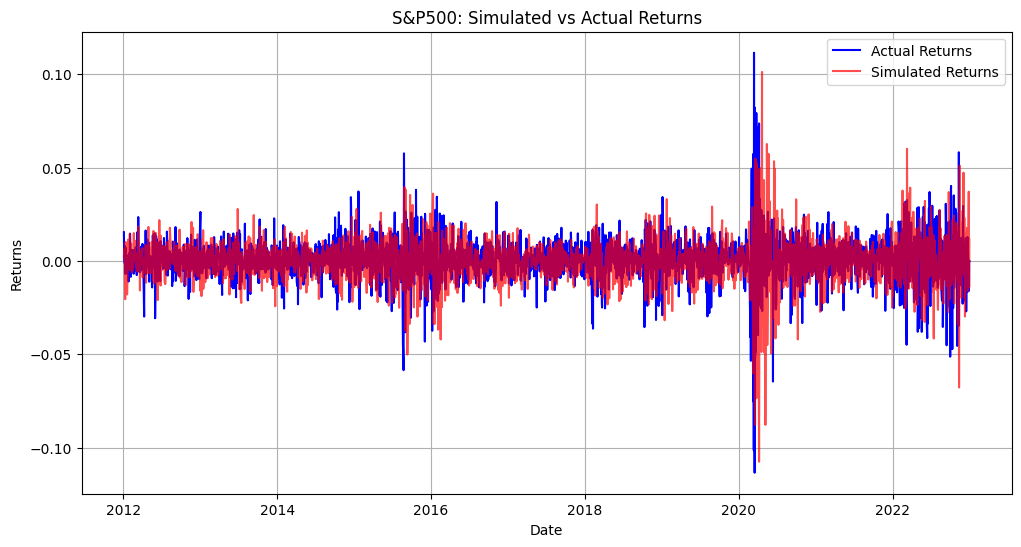

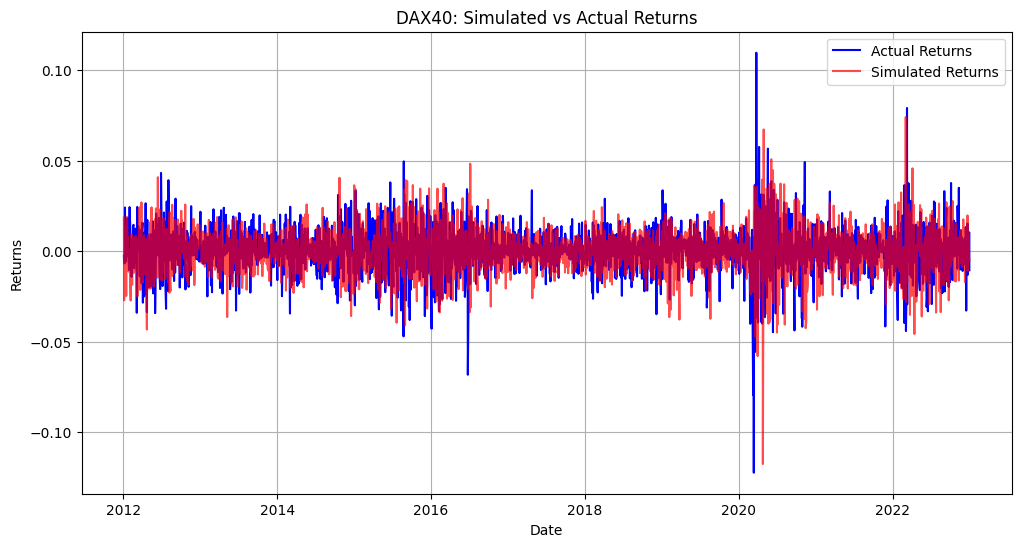

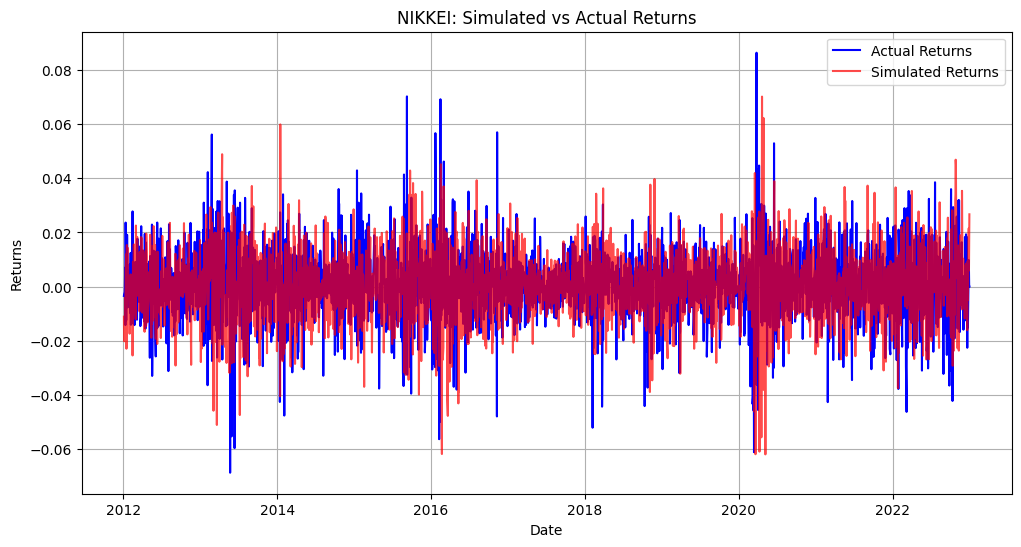

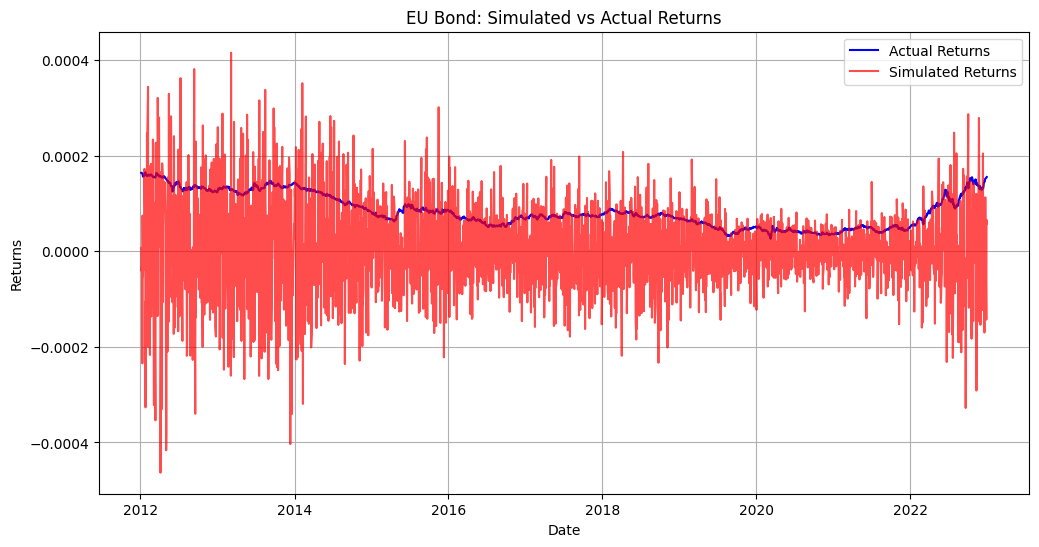

In [218]:
#plot a graphs where you plot the actual returns and the simulated returns to compare them
def plot_simulated_vs_actual_returns(
    actual_returns: pd.Series, 
    simulated_returns: pd.Series, 
    title: str = "Simulated vs Actual Returns"
) -> None:
    """
    Plot simulated returns against actual returns.

    Parameters:
    ----------
    actual_returns : pd.Series
        Series of actual returns
    simulated_returns : pd.Series
        Series of simulated returns
    title : str, optional
        Title of the plot, by default "Simulated vs Actual Returns"
    """
    plt.figure(figsize=(12, 6))
    plt.plot(actual_returns.index, actual_returns, label='Actual Returns', color='blue')
    plt.plot(simulated_returns.index, simulated_returns, label='Simulated Returns', color='red', alpha=0.7)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.grid(True)
    
    plt.show()
# Example usage
# Simulated returns for S&P500
simulated_returns_sp500 = pd.Series(
    np.random.normal(loc=0, scale=ewma_results['lambda_0.94']['C_S&P500_Returns'].values, size=len(ewma_results['lambda_0.94'])),
    index=ewma_results['lambda_0.94'].index
)
# Simulated returns for DAX40
simulated_returns_dax = pd.Series(
    np.random.normal(loc=0, scale=ewma_results['lambda_0.94']['C_Dax40_Returns'].values, size=len(ewma_results['lambda_0.94'])),
    index=ewma_results['lambda_0.94'].index
)
# Simulated returns for NIKKEI
simulated_returns_nikkei = pd.Series(
    np.random.normal(loc=0, scale=ewma_results['lambda_0.94']['C_Nikkei_Returns'].values, size=len(ewma_results['lambda_0.94'])),
    index=ewma_results['lambda_0.94'].index
)
# Simulated returns for EU Bond
simulated_returns_bond = pd.Series(
    np.random.normal(loc=0, scale=ewma_results['lambda_0.94']['Interest_Bond_daily_rate'].values, size=len(ewma_results['lambda_0.94'])),
    index=ewma_results['lambda_0.94'].index
)
# Plot actual vs simulated returns for S&P500
plot_simulated_vs_actual_returns(
    actual_returns=returns_df['C_S&P500_Returns'], 
    simulated_returns=simulated_returns_sp500, 
    title="S&P500: Simulated vs Actual Returns"
)
# Plot actual vs simulated returns for DAX40
plot_simulated_vs_actual_returns(
    actual_returns=returns_df['C_Dax40_Returns'], 
    simulated_returns=simulated_returns_dax, 
    title="DAX40: Simulated vs Actual Returns"
)
# Plot actual vs simulated returns for NIKKEI
plot_simulated_vs_actual_returns(
    actual_returns=returns_df['C_Nikkei_Returns'], 
    simulated_returns=simulated_returns_nikkei, 
    title="NIKKEI: Simulated vs Actual Returns"
)
# Plot actual vs simulated returns for EU Bond
plot_simulated_vs_actual_returns(
    actual_returns=returns_df['Interest_Bond_daily_rate'], 
    simulated_returns=simulated_returns_bond, 
    title="EU Bond: Simulated vs Actual Returns"
)
#plot the actual returns and the simulated returns for all indices in one graph
def plot_all_indices_simulated_vs_actual(
    actual_returns: pd.DataFrame, 
    simulated_returns: pd.DataFrame, 
    title: str = "Simulated vs Actual Returns for All Indices"
) -> None:
    """
    Plot simulated returns against actual returns for all indices.

    Parameters:
    ----------
    actual_returns : pd.DataFrame
        DataFrame of actual returns
    simulated_returns : pd.DataFrame
        DataFrame of simulated returns
    title : str, optional
        Title of the plot, by default "Simulated vs Actual Returns for All Indices"
    """
    plt.figure(figsize=(12, 6))
    
    for column in actual_returns.columns:
        plt.plot(actual_returns.index, actual_returns[column], label=f'Actual {column}', alpha=0.5)
        plt.plot(simulated_returns.index, simulated_returns[column], label=f'Simulated {column}', linestyle='--', alpha=0.7)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [219]:
def filter_returns(returns: pd.DataFrame, ewma_vol: dict) -> dict:
    """
    Compute standardized (filtered) returns for each lambda value.

    Parameters:
    - returns: DataFrame of raw returns
    - ewma_vol: Dictionary containing DataFrames of EWMA volatilities for each lambda

    Returns:
    - filtered_returns: Dictionary of DataFrames with standardized returns for each lambda
    """
    filtered_returns = {}
    
    # Filter returns for each lambda value
    for lambda_key, vol_df in ewma_vol.items():
        filtered_returns[lambda_key] = returns / vol_df
    
    return filtered_returns

# Assuming returns_df and ewma_vol_df (from compute_ewma_volatility) are already defined
filtered_returns_dict = filter_returns(returns_df, ewma_results)

# Preview results for both lambda values
print("\nFiltered Returns (lambda = 0.94):")
print(filtered_returns_dict['lambda_0.94'].tail())
print("\nFiltered Returns (lambda = 0.97):")
print(filtered_returns_dict['lambda_0.97'].tail())



Filtered Returns (lambda = 0.94):
            C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
Date                                                              
2022-12-23          0.355825         0.170861         -1.145478   
2022-12-27         -0.385142         0.354398          0.741127   
2022-12-28         -1.063447        -0.465302          0.467366   
2022-12-29          0.000000         1.007112          0.000000   
2022-12-30          0.000000        -1.009932          0.000000   

            Interest_Bond_daily_rate  
Date                                  
2022-12-23                  1.093727  
2022-12-27                  1.097422  
2022-12-28                  1.096478  
2022-12-29                  1.091148  
2022-12-30                  1.092670  

Filtered Returns (lambda = 0.97):
            C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
Date                                                              
2022-12-23          0.323293         0.166975        

In [220]:
def filtered_historical_simulation_multivariate(filtered_returns_dict: dict, ewma_vol_dict: dict,
                                              n_simulations: int = 10000, random_seed: int = None, 
                                              weights: np.ndarray = None) -> dict:
    """
    Perform Filtered Historical Simulation for a multi-asset portfolio for different lambda values.

    Parameters:
    - filtered_returns_dict: Dictionary of DataFrames of standardized residuals for each lambda
    - ewma_vol_dict: Dictionary of DataFrames of EWMA volatility for each lambda
    - n_simulations: number of simulated return vectors
    - random_seed: for reproducibility
    - weights: portfolio weights (numpy array of shape [n_assets])

    Returns:
    - Dictionary containing simulated portfolio returns for each lambda value
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    results = {}
    
    # Process each lambda value
    for lambda_key in filtered_returns_dict.keys():
        filtered_returns = filtered_returns_dict[lambda_key]
        # print(filtered_returns)
        ewma_vol = ewma_vol_dict[lambda_key]
        
        assets = filtered_returns.columns
        print(f"Assets: {assets}")
        n_assets = len(assets)
        
        # Initialize simulated return matrix (n_simulations x n_assets)
        sim_returns = np.zeros((n_simulations, n_assets))

        for i, asset in enumerate(assets):
            if asset == 'Date':
                continue
            z_asset = filtered_returns[asset].dropna().values
            print(f"z_asset: {z_asset}")
            z_star = np.random.choice(z_asset, size=n_simulations, replace=True)
            print(f"z_star: {z_star}")
            sigma_t = ewma_vol[asset].iloc[-1]  # latest volatility for asset
            sim_returns[:, i] = sigma_t * z_star  # re-scale

        if weights is not None:
            portfolio_simulated_returns = sim_returns @ weights
            results[lambda_key] = pd.Series(portfolio_simulated_returns, 
                                          name=f"Simulated_Portfolio_Returns_{lambda_key}")
        else:
            results[lambda_key] = pd.DataFrame(sim_returns, columns=assets)

    return results

# Define weights in the same order as your DataFrame columns
weights = np.array([0.4, 0.3, 0.15, 0.15])  # Example: S&P500, DAX, Nikkei, Bond rate

# Run multivariate FHS simulation for both lambda values
simulated_returns = filtered_historical_simulation_multivariate(
    filtered_returns_dict,
    ewma_results,
    n_simulations=10000,
    random_seed=42,
    weights=weights
)

# Compute VaR and ES for 95% and 99% for each lambda value
confidence_levels = [0.95, 0.99]
results = {}

for lambda_key, sim_returns in simulated_returns.items():
    for cl in confidence_levels:
        alpha = 1 - cl
        percentile = alpha * 100
        var = -np.percentile(sim_returns, percentile)
        es = -sim_returns[sim_returns <= -var].mean()
        results[f"{lambda_key}_VaR_{int(cl * 100)}"] = var
        results[f"{lambda_key}_ES_{int(cl * 100)}"] = es

# Print results
for lambda_key in simulated_returns.keys():
    print(f"\nResults for {lambda_key}:")
    for cl in confidence_levels:
        print(f"Portfolio 1-day VaR ({int(cl * 100)}%): {results[f'{lambda_key}_VaR_{int(cl * 100)}']:.5f}")
        print(f"Portfolio 1-day ES  ({int(cl * 100)}%): {results[f'{lambda_key}_ES_{int(cl * 100)}']:.5f}")



Assets: Index(['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns',
       'Interest_Bond_daily_rate'],
      dtype='object')
z_asset: [ 1.29487961  0.21127976 -0.11101156 ... -1.06344652  0.
  0.        ]
z_star: [ 0.55357951 -0.73285909 -1.42333096 ...  0.07726405  0.4820396
 -0.30835317]
z_asset: [-0.20720971 -0.5235188  -0.57574207 ... -0.46530224  1.00711214
 -1.00993173]
z_star: [ 0.54109009  0.86781362  1.44012185 ...  0.81558377  0.3536276
 -0.29605481]
z_asset: [-0.26132864 -0.22013563 -0.15877408 ...  0.46736635  0.
  0.        ]
z_star: [-1.469001    1.48450974  1.82126461 ... -0.78983687 -0.14394981
  0.89505563]
z_asset: [4.68747344 3.12179813 2.50996966 ... 1.09647804 1.09114795 1.0926701 ]
z_star: [1.00393218 1.01057632 0.84811626 ... 0.96727998 1.17706123 0.90040646]
Assets: Index(['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns',
       'Interest_Bond_daily_rate'],
      dtype='object')
z_asset: [ 1.29487961  0.21337137 -0.11044265 ... -0.94129411  0.
  

In [221]:
def filtered_historical_simulation_multiday(
    filtered_returns_dict: dict,
    ewma_vol_dict: dict,
    lambda_key: str,
    n_days: int = 1,
    n_simulations: int = 10000,
    random_seed: int = None,
    weights: np.ndarray = None
) -> pd.Series:
    """
    Simulate N-day portfolio returns using Filtered Historical Simulation.

    Returns:
    - Simulated N-day portfolio return series (n_simulations,)
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    filtered_returns = filtered_returns_dict[lambda_key]
    ewma_vol = ewma_vol_dict[lambda_key]

    assets = filtered_returns.columns
    n_assets = len(assets)
    sim_returns = np.zeros((n_simulations, n_days, n_assets))

    for i, asset in enumerate(assets):
        z_asset = filtered_returns[asset].dropna().values
        sigma_t = ewma_vol[asset].iloc[-1]

        if len(z_asset) == 0 or np.isnan(sigma_t):
            raise ValueError(f"Cannot simulate for asset '{asset}': empty or invalid data.")

        for day in range(n_days):
            z_star = np.random.choice(z_asset, size=n_simulations, replace=True)
            sim_returns[:, day, i] = sigma_t * z_star

    # Combine all simulated daily returns into N-day portfolio PnL
    total_pnl = (sim_returns @ weights).sum(axis=1)

    return pd.Series(total_pnl, name=f"Simulated_{n_days}Day_Returns_{lambda_key}")


# Example usage with both lambda values
confidence_levels = [0.95, 0.99]
horizons = [1, 5, 10]
lambda_keys = ['lambda_0.94', 'lambda_0.97']

for lambda_key in lambda_keys:
    print(f"\n=== Results for {lambda_key} ===")
    for days in horizons:
        print(f"\n--- {days}-Day VaR & ES ---")
        sim_returns = filtered_historical_simulation_multiday(
            filtered_returns_dict,
            ewma_results,
            lambda_key,
            n_days=days,
            n_simulations=10000,
            random_seed=42,
            weights=weights
        )

        for cl in confidence_levels:
            alpha = 1 - cl
            percentile = alpha * 100
            var = -np.percentile(sim_returns, percentile)
            es = -sim_returns[sim_returns <= -var].mean()
            print(f"VaR ({int(cl*100)}%): {var:.5f} | ES ({int(cl*100)}%): {es:.5f}")



=== Results for lambda_0.94 ===

--- 1-Day VaR & ES ---
VaR (95%): 0.01154 | ES (95%): 0.01655
VaR (99%): 0.01945 | ES (99%): 0.02441

--- 5-Day VaR & ES ---
VaR (95%): 0.02559 | ES (95%): 0.03321
VaR (99%): 0.03802 | ES (99%): 0.04476

--- 10-Day VaR & ES ---
VaR (95%): 0.03478 | ES (95%): 0.04543
VaR (99%): 0.05209 | ES (99%): 0.06182

=== Results for lambda_0.97 ===

--- 1-Day VaR & ES ---
VaR (95%): 0.01269 | ES (95%): 0.01817
VaR (99%): 0.02145 | ES (99%): 0.02740

--- 5-Day VaR & ES ---
VaR (95%): 0.02803 | ES (95%): 0.03659
VaR (99%): 0.04204 | ES (99%): 0.04925

--- 10-Day VaR & ES ---
VaR (95%): 0.03830 | ES (95%): 0.04991
VaR (99%): 0.05619 | ES (99%): 0.06798


In [309]:
def rolling_fhs_multiday_var_es(
    returns_df: pd.DataFrame,
    weights: np.ndarray,
    window_size: int = 500,
    horizons: list = [1, 5, 10],
    confidence_levels: list = [0.95, 0.99],
    n_simulations: int = 1000,
    lambdas: list = [0.94, 0.97],
    random_seed: int = None
) -> tuple:
    """
    Rolling Filtered Historical Simulation for multi-day VaR & ES.
    """
    time_window = returns_df.loc['2012-01-05':'2021-12-31']

    var_results = []
    es_results = []

    for horizon in horizons:
        #adjusted_window_size = int(window_size / horizon)

        for t in range(window_size, len(time_window)):
            current_date = time_window.index[t]
            var_row = {'index': current_date}
            es_row = {'index': current_date}

            window = time_window.iloc[t - window_size:t]


            try:
                # Compute EWMA vol
                ewma_results = compute_ewma_volatility(
                    window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']],
                    lambdas
                )
                # Filtered returns
                filtered_returns_dict = {}
                for lambda_key, vol_df in ewma_results.items():
                    safe_vol_df = vol_df.replace(0, np.nan).fillna(method='ffill')
                    filtered_returns = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']] / safe_vol_df
                    filtered_returns_dict[lambda_key] = filtered_returns

                # Simulate for each lambda and confidence level
                for lambda_key in ewma_results.keys():
                    sim_returns = filtered_historical_simulation_multiday(
                        filtered_returns_dict,
                        ewma_results,
                        lambda_key,
                        n_days=horizon,
                        n_simulations=n_simulations,
                        weights=weights,
                        random_seed=random_seed
                    )

                    for cl in confidence_levels:
                        alpha = 1 - cl
                        var = np.percentile(sim_returns, 100 * alpha)
                        es = sim_returns[sim_returns <= var].mean()

                        var_key = f"VaR_{int(cl * 100)}_{lambda_key}_h{horizon}"
                        es_key = f"ES_{int(cl * 100)}_{lambda_key}_h{horizon}"

                        var_row[var_key] = var
                        es_row[es_key] = es

                    var_results.append(var_row)
                    es_results.append(es_row)

            except Exception as e:
                continue
    var_df = pd.DataFrame(var_results).set_index('index')
    es_df = pd.DataFrame(es_results).set_index('index')

    var_df.index.name = 'Date'
    es_df.index.name = 'Date'

    return var_df, es_df

In [310]:
def count_violations(var_df, es_df, actual_returns_dict, lambdas, horizons, confidence_levels):
    """
    Count the number of violations for VaR.

    Returns:
    - violations: DataFrame with counts of violations for each lambda and horizon
    """
    violations = pd.DataFrame(index=horizons, columns=lambdas)

    for h in horizons:
        actual_returns = actual_returns_dict[h]

        for lambda_ in lambdas:
            lambda_key = f"lambda_{lambda_}"
            total_violations = 0

            for cl in confidence_levels:
                var_col = f"VaR_{int(cl * 100)}_{lambda_key}_h{h}"

                # Align the two series
                aligned_df = pd.concat([
                    actual_returns,
                    var_df[[var_col]]
                ], axis=1, join='inner').dropna()

                aligned_df.columns = ['actual', 'var']

                # Count violations
                count = (aligned_df['actual'] < aligned_df['var']).sum()
                total_violations += count

            violations.at[h, lambda_] = total_violations

    return violations


In [311]:
# import matplotlib.pyplot as plt

# def plot_var_es_vs_actual_given_actuals(var_df, es_df, actual_returns_dict, lambdas, horizons, confidence_levels):
#     """
#     Plot VaR and ES against already computed actual portfolio returns.

#     Parameters:
#     - var_df: DataFrame of rolling VaR values
#     - es_df: DataFrame of rolling ES values
#     - actual_returns_dict: Dict of actual portfolio return Series keyed by horizon
#     - lambdas: list of lambda values used (e.g. [0.94, 0.97])
#     - horizons: list of horizon days (e.g. [1, 5, 10])
#     - confidence_levels: list of confidence levels (e.g. [0.95, 0.99])
#     """

#     for h in horizons:
#         actual_returns = actual_returns_dict[h].reindex(var_df.index).sort_index()
#         actual_returns = actual_returns[~actual_returns.index.duplicated(keep='first')]  

#         # Plot for each lambda value separately
#         for lambda_ in lambdas:
#             lambda_key = f"lambda_{lambda_}"
#             plt.figure(figsize=(14, 5))
            
#             # Plot actual returns
#             plt.plot(actual_returns, label="Actual Portfolio Return", alpha=0.6)
            
#             # Plot both 95% and 99% VaR and ES for this lambda
#             for cl in confidence_levels:
#                 var_col = f"VaR_{int(cl * 100)}_{lambda_key}_h{h}"
#                 #es_col = f"ES_{int(cl * 100)}_{lambda_key}_h{h}"
                
#                 plt.plot(var_df[var_col], 
#                         label=f"VaR {int(cl * 100)}%", 
#                         linestyle='--')
#                 # #plt.plot(es_df[es_col], 
#                 #         label=f"ES {int(cl * 100)}%", 
#                 #         linestyle=':')



#             plt.title(f"{h}-Day VaR and ES vs Actual Returns | λ={lambda_}")
#             plt.axhline(0, color='gray', linestyle='-')
#             plt.legend()
#             plt.grid(True)
#             plt.tight_layout()
#             plt.show()


In [312]:
import matplotlib.pyplot as plt

def plot_var_es_vs_actual_given_actuals(var_df, es_df, actual_returns_dict, lambdas, horizons, confidence_levels):
    """
    Plot VaR and ES against already computed actual portfolio returns and mark violations.

    Parameters:
    - var_df: DataFrame of rolling VaR values
    - es_df: DataFrame of rolling ES values
    - actual_returns_dict: Dict of actual portfolio return Series keyed by horizon
    - lambdas: list of lambda values used (e.g. [0.94, 0.97])
    - horizons: list of horizon days (e.g. [1, 5, 10])
    - confidence_levels: list of confidence levels (e.g. [0.95, 0.99])
    """

    for h in horizons:
        actual_returns = actual_returns_dict[h].reindex(var_df.index).sort_index()
        actual_returns = actual_returns[~actual_returns.index.duplicated(keep='first')]  

        for lambda_ in lambdas:
            lambda_key = f"lambda_{lambda_}"
            plt.figure(figsize=(14, 5))
            plt.plot(actual_returns, label="Actual Portfolio Return", alpha=0.6)

            title_addon = ""

            for cl in confidence_levels:
                var_col = f"VaR_{int(cl * 100)}_{lambda_key}_h{h}"
                var_series = var_df[var_col]
                plt.plot(var_series, label=f"VaR {int(cl * 100)}%", linestyle='--')

                # Find violations
                actual_aligned, var_aligned = actual_returns.align(var_series, join='inner')
                violations = actual_aligned < var_aligned
                violation_points = actual_aligned[violations]


                # Mark violations with different styles
                if cl == 0.95:
                    plt.scatter(violation_points.index, violation_points, 
                                color='red', label="VaR 95% Violation", marker='x', s=50)
                elif cl == 0.99:
                    plt.scatter(violation_points.index, violation_points, 
                                color='purple', label="VaR 99% Violation", marker='v', s=60)

                # Count violations and append to title
                total_obs = actual_returns.dropna().shape[0]
                violation_count = len(violation_points)
                percentage = violation_count / total_obs * 100
                title_addon += f" | {int(cl*100)}% Viol: {violation_count} ({percentage:.2f}%)"

            plt.title(f"{h}-Day VaR and ES vs Actual Returns | λ={lambda_}{title_addon}")
            plt.axhline(0, color='gray', linestyle='-')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


In [313]:
def compute_actual_portfolio_returns(returns_df, weights, horizons=[1, 5, 10]):
    actual_returns = {}
    weighted_returns = returns_df @ weights

    for h in horizons:
        actual_returns[h] = weighted_returns.rolling(window=h).sum().shift(-h + 1)
        actual_returns[h].name = f"Actual_{h}d"

    return actual_returns

actual_returns_dict = compute_actual_portfolio_returns(returns_df, weights)
returns_dfe = pd.DataFrame(actual_returns_dict)




/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/1300752270.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol_df = vol_df.replace(0, np.nan).fillna(method='ffill')
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/1300752270.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol_df = vol_df.replace(0, np.nan).fillna(method='ffill')
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/1300752270.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol_df = vol_df.replace(0, np.nan).fillna(method='ffill')
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/1300752270.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and w

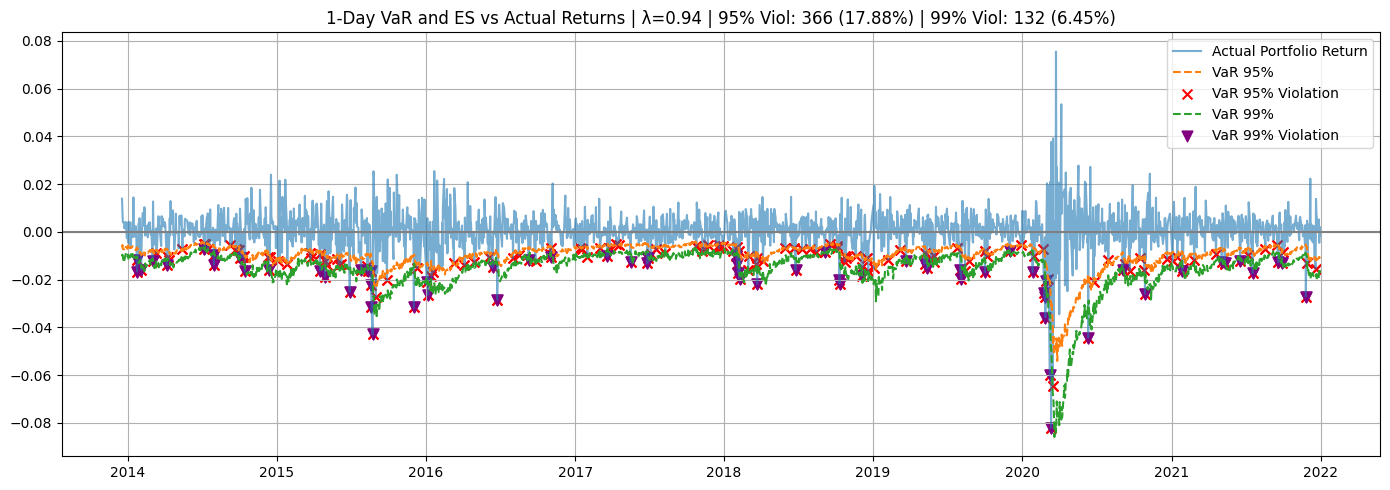

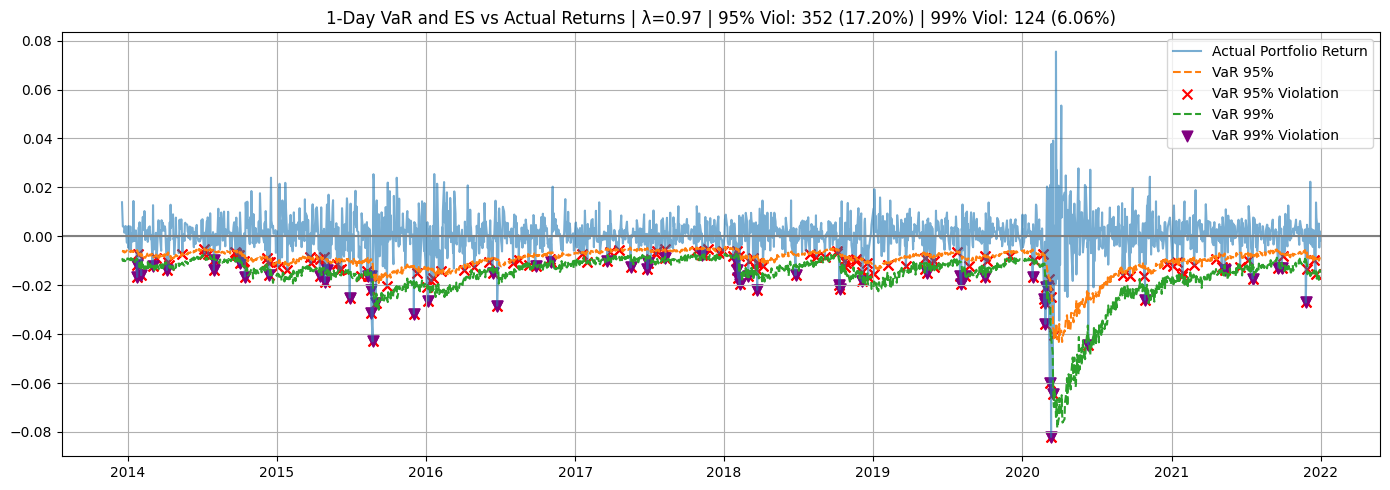

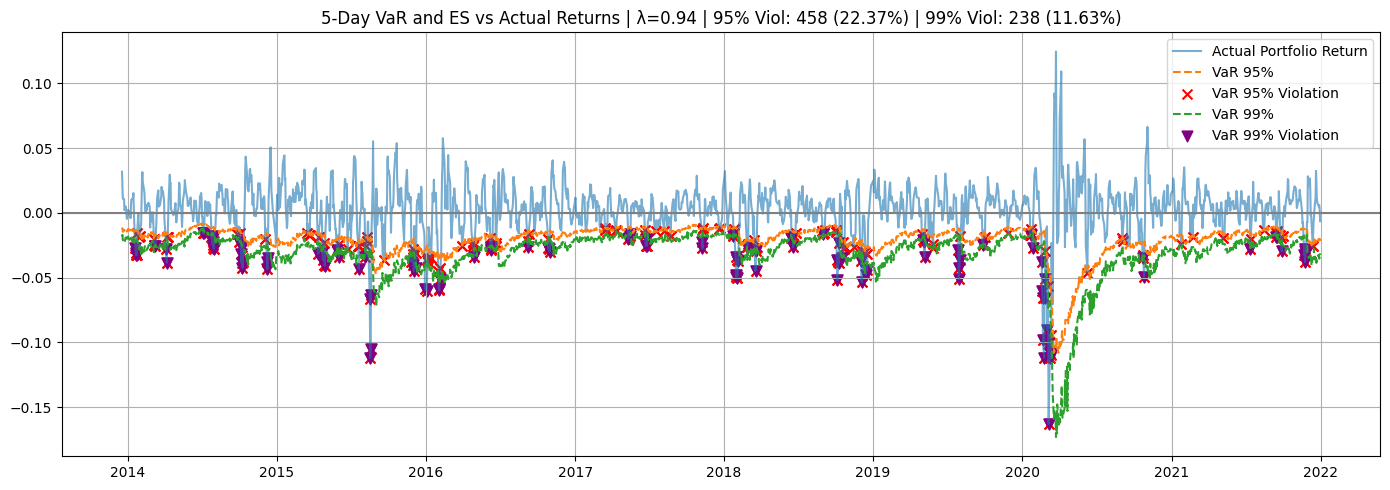

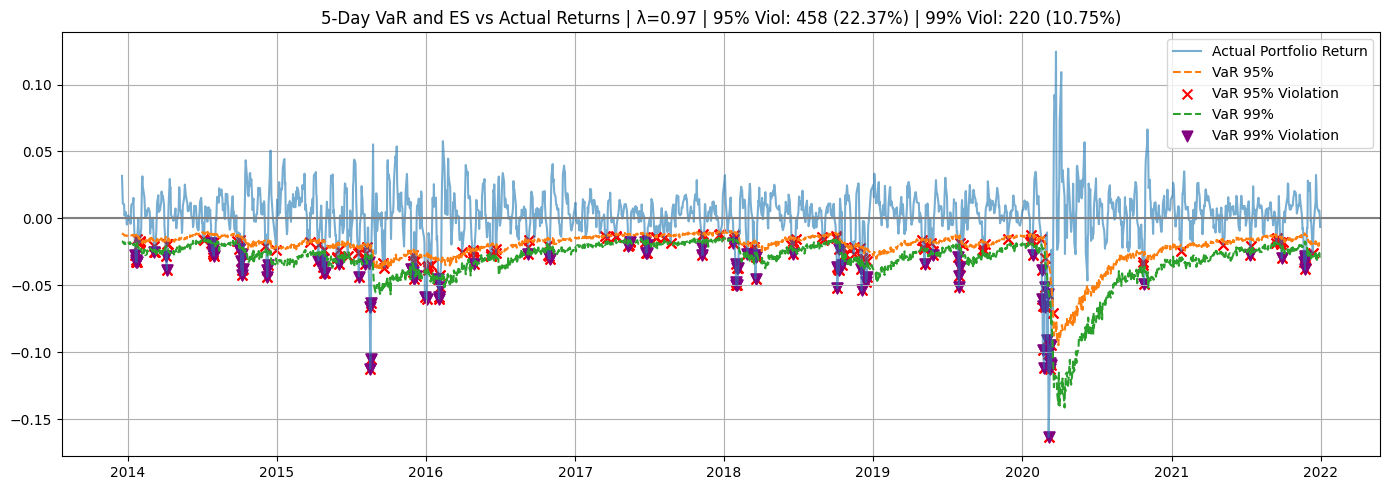

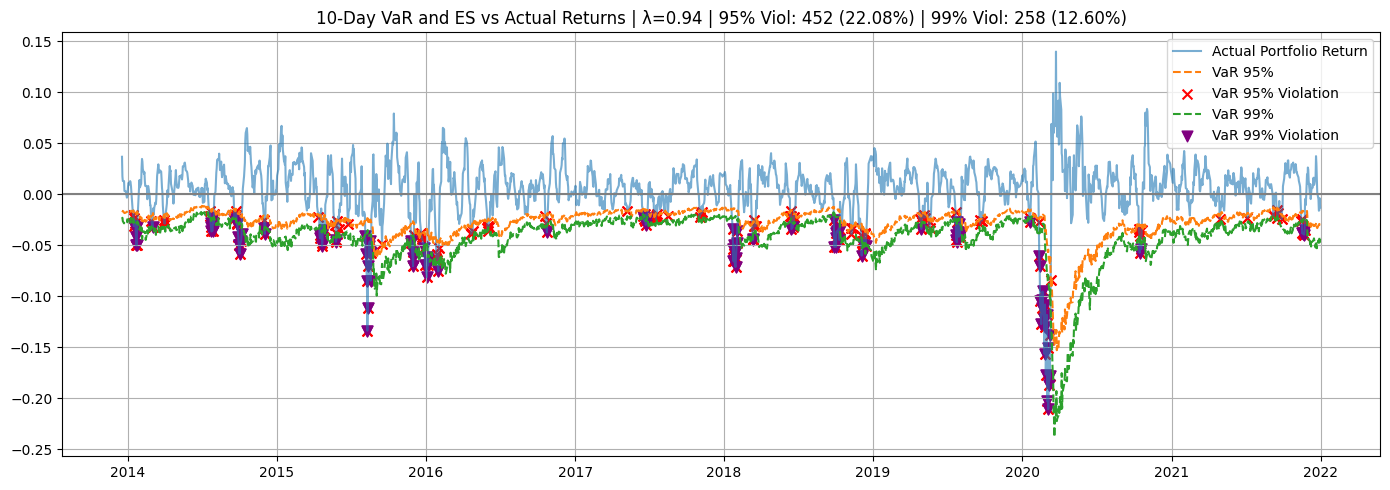

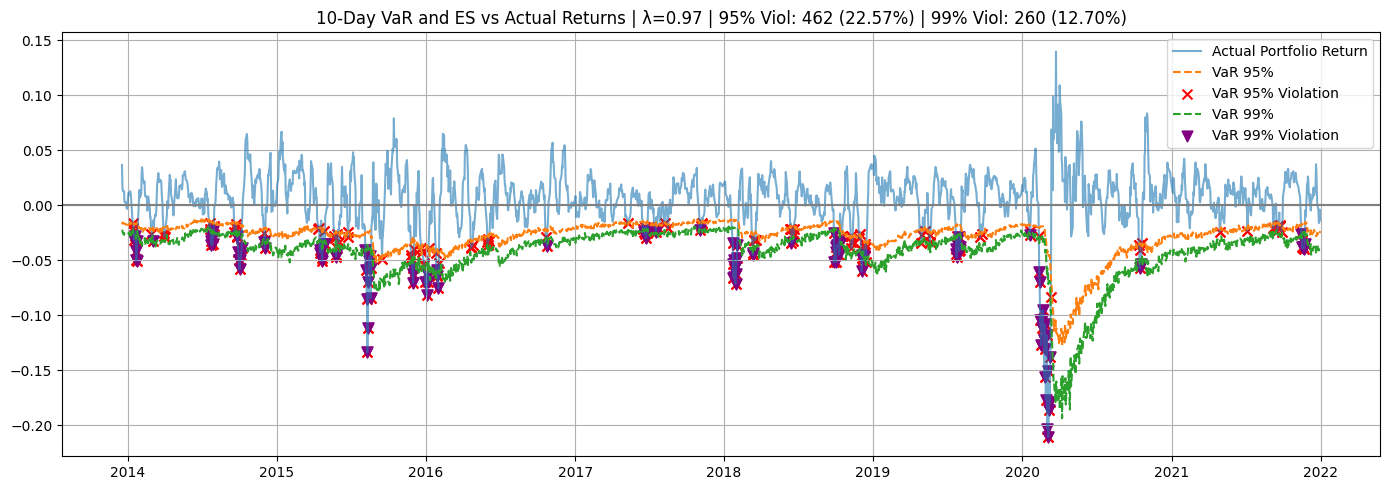

In [318]:
# Calculate VaR and ES using rolling FHS
var_df, es_df = rolling_fhs_multiday_var_es(
    returns_df=returns_df,  # DataFrame containing returns
    weights=weights,        # Portfolio weights
    window_size=500,       # Base window size
    horizons=[1, 5, 10],   # Horizons for VaR calculation
    confidence_levels=[0.95, 0.99],  # Confidence levels
    n_simulations=1000,    # Number of simulations
    lambdas=[0.94, 0.97]   # EWMA lambda values
)

# Plot the results
plot_var_es_vs_actual_given_actuals(
    var_df=var_df,
    es_df=es_df,
    actual_returns_dict=actual_returns_dict,
    lambdas=[0.94, 0.97],
    horizons=[1, 5, 10],
    confidence_levels=[0.95, 0.99]
)



In [227]:
#maximum likelihood estimation of GARCH(1,1) parameters
def garch_likelihood(params, returns):
    omega, alpha, beta = params
    T = len(returns)
    var = np.zeros(T)
    var[0] = omega / (1 - alpha - beta)
    ll = 0
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
        ll += 0.5 * (np.log(2 * np.pi) + np.log(var[t]) + returns[t]**2 / var[t])
    return ll


In [228]:
# GARCH(1,1) parameter estimation using MLE
# This function estimates the parameters of a GARCH(1,1) model using maximum likelihood estimation (MLE).
def parameter_estimation_GARCH(returns):
    # Run the optimization
    result = minimize(
        garch_likelihood,
        x0=[0.00002, 0.05, 0.9],
        args=(returns,),
        method='SLSQP',
        bounds=[(1e-6, None), (0, 0.99), (0, 0.99)],
        constraints=[
            {'type': 'ineq', 'fun': lambda x: 0.999 - x[1] - x[2]}
        ],
        options={'disp': True}
    )

    # Return the optimization result
    return result

# # Check the optimization result
# if result.success:
#     print(f"Optimized parameters: omega={result.x[0]}, alpha={result.x[1]}, beta={result.x[2]}")
# else:
#     print("Optimization failed:", result.message)


In [229]:
# calculate the GARCH(1,1) volatility for returns t
def garch_volatility(returns):
    param = parameter_estimation_GARCH(returns)
    omega, alpha, beta = param.x
    T = len(returns)
    var = np.zeros(T)
    var[0]= param.x[0] / (1 - param.x[1] - param.x[2])
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
    return np.sqrt(var)

In [230]:
# calculate correlation matrix of the 4 time series
# the method must take the returns as matrix of 4 vectors and return the correlation matrix
def correlation_matrix(returns):
    # Calculate the covariance matrix
    cov_matrix = np.cov(returns.T)
    
    # Calculate the standard deviations of each asset
    std_devs = np.sqrt(np.diag(cov_matrix))
    
    # Calculate the correlation matrix
    corr_matrix = cov_matrix / np.outer(std_devs, std_devs)
    
    return corr_matrix


In [231]:
# calculate the diagonal matrix with the garch volatility of the 4 time series
def diagonal_matrix(returns):
    # Initialize an empty dictionary to store volatilities for each column
    volatilities_dict = {}

    # Iterate through each column in the returns DataFrame
    for column in returns.columns:
        # Reset the index of the column to ensure numeric indexing
        column_returns = returns[column].dropna().reset_index(drop=True)
        
        # Calculate the GARCH(1,1) volatility for the column
        volatilities_dict[column] = garch_volatility(column_returns)
        
    # Combine the volatilities into a single array
    volatilities = np.array([vol[-1] for vol in volatilities_dict.values()])

    # Create a diagonal matrix with the volatilities
    #diag_matrix = np.diag(volatilities)
    
    return volatilities

In [232]:
# calculate the covariance matrix of the 4 time series
def covariance_matrix(returns):
    # Calculate the GARCH(1,1) volatilities
    volatilities = diagonal_matrix(returns)
    
    # Calculate the correlation matrix
    corr_matrix = correlation_matrix(returns)
    
    # Calculate the covariance matrix
    cov_matrix = np.outer(volatilities, volatilities) * corr_matrix
    
    return cov_matrix

In [233]:
# method to calculate the portfolio variance and volatility
def portfolio_variance(weights, cov_matrix):
    # Calculate the portfolio variance
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Calculate the portfolio volatility
    port_volatility = np.sqrt(port_variance)
    
    return port_variance, port_volatility

In [234]:
# method to calculate the VaR and ES of the portfolio using the normal distribution
def portfolio_VaR_ES(weights, cov_matrix, alpha=0.95):
    # Calculate the portfolio variance and volatility
    _, port_volatility = portfolio_variance(weights, cov_matrix)
    
    # Calculate the VaR using the normal distribution
    VaR = -port_volatility * st.norm.ppf(1 - alpha)
    
    # Calculate the ES using the normal distribution
    ES = -port_volatility * (st.norm.pdf(st.norm.ppf(1 - alpha)) / (1 - alpha))
    
    return VaR, ES

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1695.0334226114517
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1492.2729773036988
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1446.9797214703117
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1666.5550041095755
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1741.3075703067668
            Iterations: 7
            Function evaluation

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1734.154532739282
            Iterations: 7
            Function evaluations: 14
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1502.2676364300692
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1418.3442310151272
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.8950527625957
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1573.951700931955
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyth

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1692.7920836078188
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1501.760211983212
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -846.2097219351193
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.8952796297963
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1576.44161042399
            Iterations: 5
            Function evaluations: 4

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Inequality constraints incompatible    (Exit mode 4)
            Current function value: -999.5825631617795
            Iterations: 22
            Function evaluations: 98
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.89648620821
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1574.5592772231937
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.9284906584455
            Iterations: 12
            Function evaluations: 47
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1418.4596160277392
            Iterations: 2
            Function evaluation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -349.8917225796541
            Iterations: 23
            Function evaluations: 112
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1393.8350135014134
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.897468376181
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1683.0808235181564
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1504.8392721087162
            Iterations: 5
            Function evaluatio

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.9380338567198
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1513.6363280170278
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1401.1786115082266
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.8987285035869
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.7231070533624
            Iterations: 5
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1581.436498417558
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1526.1244746987088
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1409.5633855749386
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.8990999818373
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1581.8457244619917
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1556.0493150416075
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1503.2042350587542
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1406.3990535500939
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9032806013774
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1555.8393807548157
            Iterations: 5
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1555.7221428856153
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1506.878984679765
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1410.6395385355052
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.904274564009
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1555.5526002084237
            Iterations: 5
            Function evaluations: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1552.1884108443378
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.0520317709713
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1420.1517864776872
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9053035315408
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1551.1805351080727
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1544.7668954906233
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1501.1720764602596
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1431.369078015095
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9058243195002
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1639.8039853196801
            Iterations: 6
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sq

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1542.480052555783
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1497.199930315012
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.2473282924507
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9071824248035
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1540.3555276065706
            Iterations: 5
            Function evaluations: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1636.3745878139857
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1491.0024761075135
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1442.495334586046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9075708790624
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1542.3000637133166
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1542.7571402183382
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1548.6221165544032
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1447.3984441894472
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9079890540527
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1636.3339482217862
            Iterations: 6
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1517.58706416912
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1476.6035369620383
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -675.8823573058861
            Iterations: 4
            Function evaluations: 27
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9089377213195
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1516.963189403889
            Iterations: 5
            Function evaluations: 4


/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1620.7761129744404
            Iterations: 9
            Function evaluations: 26
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1470.3032911041478
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1473.0015259462239
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9094153227927
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -851.4867366735227
            Iterations: 7
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1513.7673842869988
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1466.0462060598534
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1426.5115367632009
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9098695287055
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1513.046873391861
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.162487041095
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1458.6507421964993
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1432.0230808854583
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.91065669747
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1506.1914380465992
            Iterations: 5
            Function evaluations: 4

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1499.5952296456662
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1492.6605534651778
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1430.0459796349155
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9110785079702
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1500.0960620728333
            Iterations: 5
            Function evaluation

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1497.1387184157386
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1451.7696392516675
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1431.7936650958586
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.911596270267
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1496.617011605703
            Iterations: 5
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1486.44258486519
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1444.231819026625
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1463.2889128542204
            Iterations: 34
            Function evaluations: 161
            Gradient evaluations: 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9122222917745
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.740640963658
            Iterations: 7
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1482.000004767893
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1434.283209389573
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1416.7816606818792
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2980.172405994235
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1481.0012581060084
            Iterations: 5
            Function evaluations: 4

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: V

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1522.3588839025485
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1450.0355559184543
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1400.0270894915157
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9153456237962
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1524.512400605767
            Iterations: 6
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1471.021192577525
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1419.2841925064079
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1405.5389606833164
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9160248227695
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1472.6245263871415
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1472.578000887364
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1420.7493967267867
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1428.4720547578452
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9165512511577
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1521.360164564922
            Iterations: 6
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1468.0635002922525
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1434.0354062594834
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1427.674481146217
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9172628583653
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1355.788786271121
            Iterations: 7
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1160.2820676440833
            Iterations: 39
            Function evaluations: 185
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1405.9738985691135
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9175281543926
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1467.6160782341135
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1408.0683788620322
            Iterations: 5
            Function evaluat

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1396.946948619552
            Iterations: 10
            Function evaluations: 39
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1393.9431090498301
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9181433951312
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1464.1526418562455
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1408.7218610577338
            Iterations: 12
            Function evaluatio

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1513.246741975137
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 4
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -598.9352729794298
            Iterations: 8
            Function evaluations: 28
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1393.7306935900374
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.918554359562
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1516.7890491038577
            Iterations: 9
            Function ev

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -943.6408700954574
            Iterations: 11
            Function evaluations: 44
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9188644601752
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1464.2304266720976
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1390.1802199845397
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1396.0700525908435
            Iterations: 5
            Function evaluation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -704.2555882379824
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1388.2499723474175
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1382.6997208441207
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9196661423844
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1503.3469430815135
            Iterations: 7
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1242.7190951036616
            Iterations: 47
            Function evaluations: 212
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1380.6521255355708
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9199412285523
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1518.253513213958
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1390.2875276322804
            Iterations: 5
            Function evaluat

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1208.430120497731
            Iterations: 34
            Function evaluations: 150
            Gradient evaluations: 30
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1378.379369257096
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9202218942037
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1472.5861345316077
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1399.0263866158919
            Iterations: 5
            Function evaluatio

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1537.2683196159844
            Iterations: 17
            Function evaluations: 95
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1418.0412635883408
            Iterations: 10
            Function evaluations: 41
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1415.824732434507
            Iterations: 7
            Function evaluations: 18
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.920337934798
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1474.5541165303873
            Iterations: 5
            Function evaluat

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1470.5445609503277
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1401.878070103282
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1401.9458601221365
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.920634710862
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1520.3729393936997
            Iterations: 8
            Function evaluations: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1296.2072281099224
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1404.6996031506867
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -833.5821176198925
            Iterations: 7
            Function evaluations: 24
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9208911683781
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1470.1884829627277
            Iterations: 5
            Function evaluation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Inequality constraints incompatible    (Exit mode 4)
            Current function value: -599.9205017602122
            Iterations: 4
            Function evaluations: 27
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1368.1157916266407
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9210940071926
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1472.5109870453505
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1407.9482695823162
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1484.6684137055015
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1421.617231049783
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1387.9290570495812
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.92117606066
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1485.2600149181615
            Iterations: 5
            Function evaluations: 4

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1484.5324859488953
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1421.265278799772
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1403.1472912229833
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9211861781441
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1484.456675315251
            Iterations: 5
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1541.9385596321847
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1413.0858319376773
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1421.5549995160154
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9212324144617
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1479.887962337071
            Iterations: 5
            Function evaluation

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1479.017869112821
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1421.0396749617287
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1408.531816466233
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9212178604205
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1541.916185311723
            Iterations: 7
            Function evaluations: 1

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1480.4248393111257
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -759.6272242700835
            Iterations: 12
            Function evaluations: 46
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1425.6412996885133
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9211664643744
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1546.9475973271556
            Iterations: 7
            Function evaluatio

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1272.8797776248157
            Iterations: 20
            Function evaluations: 92
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9210550274777
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1476.5718322579582
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1418.3228062837024
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -562.8015848664519
            Iterations: 8
            Function 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1493.7825263150032
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1430.3180443351034
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1413.5365773467458
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9210294642187
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1492.4175561790219
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1491.8728941331221
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1412.1548359568092
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1405.187596052785
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -2981.1080331550793
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1489.2049154428514
            Iterations: 5
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1573.320570605888
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1499.9229646745948
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1423.013380566123
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9214117244144
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1498.0445911717463
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1438.0436028112672
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1468.7174965851152
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1462.5877198991104
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9216129252907
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1515.2085898820746
            Iterations: 5
            Function evaluation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1524.7779254424042
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1477.1258917044793
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1410.5614561558793
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9217113657262
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1611.340501437461
            Iterations: 6
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1505.9146863701508
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1481.166476310767
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.8492721027935
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9218626047675
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1526.6799450063675
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1687.5121446779438
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1533.763495261354
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1503.0490128522304
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9222865318106
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1573.3757886426833
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.6124977516138
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1623.0451703214867
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1485.8028314168193
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9221479805035
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1569.7051248745934
            Iterations: 5
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1707.0322422039178
            Iterations: 11
            Function evaluations: 44
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1636.580777862086
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1509.3434055322862
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9219095570515
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.967077543526
            Iterations: 5
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1564.170718370248
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1558.2645718756082
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1516.467249166939
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.921703635074
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1715.0347860645095
            Iterations: 7
            Function evaluations: 1

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1569.2406886457989
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.752420867774
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1528.4834715783545
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9209331070556
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1569.9576498639024
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1659.9244489078696
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1559.9126709019176
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1608.0673263565873
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9205896499952
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1555.9311703144813
            Iterations: 5
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1549.501124940376
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1552.3215668972507
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1520.5948301516332
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.920557447007
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1548.9984746031953
            Iterations: 5
            Function evaluations: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1528.3534591045361
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1540.4437545986666
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1582.3146362335171
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9211205180407
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1539.0472713313115
            Iterations: 5
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1536.6213661129466
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1624.2780839084783
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1505.6896110968992
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.921814432602
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1534.3923061390647
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1530.9219091802665
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1530.267845163685
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1505.2427566997096
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9227014078563
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1530.6010328175698
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1530.957836664061
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1612.282436656089
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1488.6921147129842
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9230178153762
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1529.3769692147612
            Iterations: 5
            Function evaluations: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1524.3293874889557
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1607.3962611165396
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1506.041271534544
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9238855697881
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1521.3755252916167
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1473.5640472098105
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9245678864784
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1552.697197400794
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1521.4586370820164
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1471.9660320861533
            Iterations: 5
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sq

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1445.9981042150853
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1495.8232000534863
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1449.9758481912868
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9253474397847
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1447.2678864426337
            Iterations: 5
            Function evaluation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyth

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1444.3264015181232
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1436.0467567015162
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1447.6053286414103
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.925599566487
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1492.2750327778335
            Iterations: 6
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sq

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1441.8271290826472
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1482.172844931416
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1443.399370452558
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9258041391947
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1441.2499314435047
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1488.497702172151
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1432.4493310134353
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1442.4032239472147
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9258977202385
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.782482438612
            Iterations: 5
            Function evaluations: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sq

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1432.533234563778
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1427.4165883845337
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1411.2969299181034
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.925992746035
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1513.26541599036
            Iterations: 10
            Function evaluations: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1470.1352114076217
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1422.5350826587655
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1437.8634277510002
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9261135388115
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1424.2241641460125
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1478.4227995399185
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1465.561385400828
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1453.473814452099
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9265493501812
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1472.2537693926884
            Iterations: 6
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1489.5490324407178
            Iterations: 33
            Function evaluations: 175
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9267962891804
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1422.8603266869823
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1453.6001025431015
            Iterations: 22
            Function evaluations: 124
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.0836604124884
            Iterations: 5
            Function eva

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1440.3106139404845
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9269895744537
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1519.8106860823377
            Iterations: 6
            Function evaluations: 37
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1409.0387243978475
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1451.972694838241
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1426.4583630398643
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1402.4597965068272
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1451.38491781733
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9271775367718
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1434.2919102125093
            Iterations: 5
            Function evaluations: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1495.2588969101148
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1415.2283718758192
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1461.60700557943
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9272725086132
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1492.6019348092082
            Iterations: 6
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sq

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1444.972106008597
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1400.8604664071925
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.154550500499
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9275166050209
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1496.961679015388
            Iterations: 6
            Function evaluations: 9

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.805718250266
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9276061674047
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1443.4385104359335
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1418.8244637074743
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1454.6222942077356
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1438.3945105241748
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1413.0411384871732
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.374874303099
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9277639974703
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1437.6781003367812
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1485.516165875422
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1409.4602834920795
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1453.627668896776
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9278535973308
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.3886547038371
            Iterations: 5
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.39566771716
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1409.8063140923064
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1445.2381656125417
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9279948178664
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1433.8620650826024
            Iterations: 5
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.293637036156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1412.5921625614221
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1477.6514524069735
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9280944661905
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1438.837399402851
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1437.1833032541483
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1311.6981434357072
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1442.0000122738315
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9281075633571
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.038431871585
            Iterations: 5
            Function evaluation

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1426.349440610121
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1402.3416189097145
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1428.7443913406091
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9281360705518
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1513.011552453671
            Iterations: 9
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1492.5265891533738
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1405.4863692745537
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1434.3021671815657
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9281515232271
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1488.5956857548908
            Iterations: 6
            Function evaluation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1444.3085873592904
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1419.1300918578536
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1432.6364010120067
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9280995548831
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1446.531813054958
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1514.3012505687118
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1413.4504564934205
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1433.20784668456
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9280213021352
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1447.50596869384
            Iterations: 5
            Function evaluations: 4

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1535.339273300662
            Iterations: 9
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1420.5428677774437
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1453.976796994973
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9279300843546
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1446.6562030361247
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1505.8843683133653
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1418.3950823058283
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1426.1891633963367
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9279284735717
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1444.7428074928916
            Iterations: 5
            Function evaluation

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1484.273573812617
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1409.3933962219285
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -572.5946974835824
            Iterations: 4
            Function evaluations: 27
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.927922188517
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1437.825439227466
            Iterations: 5
            Function evaluations: 4


/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1434.186230304093
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1409.3614727149602
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1418.3402015042468
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9279407126903
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1479.3993173538652
            Iterations: 6
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1426.5065724937144
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1402.2979002651969
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1409.0658197655212
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9279512966575
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1429.786713853615
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1427.0195767564505
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1442.4157057268874
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1401.0219351598817
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9278798090227
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1498.1968049106827
            Iterations: 6
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1466.458739339213
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -812.5151129286596
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1422.517010949638
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9276574474545
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1433.1533353324871
            Iterations: 34
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1470.0680149248929
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1423.0890189565457
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1429.9994622625975
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9275448673156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1477.6368540365675
            Iterations: 5
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Inequality constraints incompatible    (Exit mode 4)
            Current function value: -716.1902115861632
            Iterations: 20
            Function evaluations: 92
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9271594021282
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1541.6599965004082
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1423.5605283433997
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1440.873410823067
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside 

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1465.2814118829172
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1505.4901660647597
            Iterations: 21
            Function evaluations: 109
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1433.5453936406439
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.926760565188
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1470.125317190894
            Iterations: 5
            Function evaluatio

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sq

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1479.9502133758108
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1444.9940611671673
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1446.1311941957558
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9263955840197
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1471.4757328934118
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside 

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1533.4805858769344
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1456.7160731190156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1276.867321650368
            Iterations: 16
            Function evaluations: 76
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9258544714687
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1529.4624997733322
            Iterations: 6
            Function evaluation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sq

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1471.5297297301142
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1503.7320976456585
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1441.5109805130576
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.924784605546
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1472.5837232239985
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sq

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1523.361120622115
            Iterations: 8
            Function evaluations: 21
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1452.009996518429
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.6278685526472
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.924394757923
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1459.7755905752194
            Iterations: 5
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1465.9761813576945
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1509.7202726008547
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1437.207715161873
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9236354026712
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1463.5823892544468
            Iterations: 5
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1460.834573701982
            Iterations: 48
            Function evaluations: 229
            Gradient evaluations: 44
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9233354409657
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1459.5852828141208
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1502.131906810226
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1258.5540672641425
            Iterations: 6
            Function evaluatio

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1446.996115911999
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1500.7066215269815
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1416.1607976327346
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.922391916504
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1450.5217023207138
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1449.1749423925683
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1469.0908291361104
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1419.6317788905249
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9216851124872
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1502.8987915874031
            Iterations: 13
            Function evaluation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.356525183009
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1512.2555146594648
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1413.5525431292976
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9202999636154
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.2632792453046
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside 

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.9723285118805
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1504.8385995309852
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1414.7592960189538
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.919829268233
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1466.8982478610621
            Iterations: 7
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyth

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1429.5138070115813
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1465.5373106359527
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1413.3664307507026
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9189497134248
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1460.5007210418319
            Iterations: 7
            Function evaluations

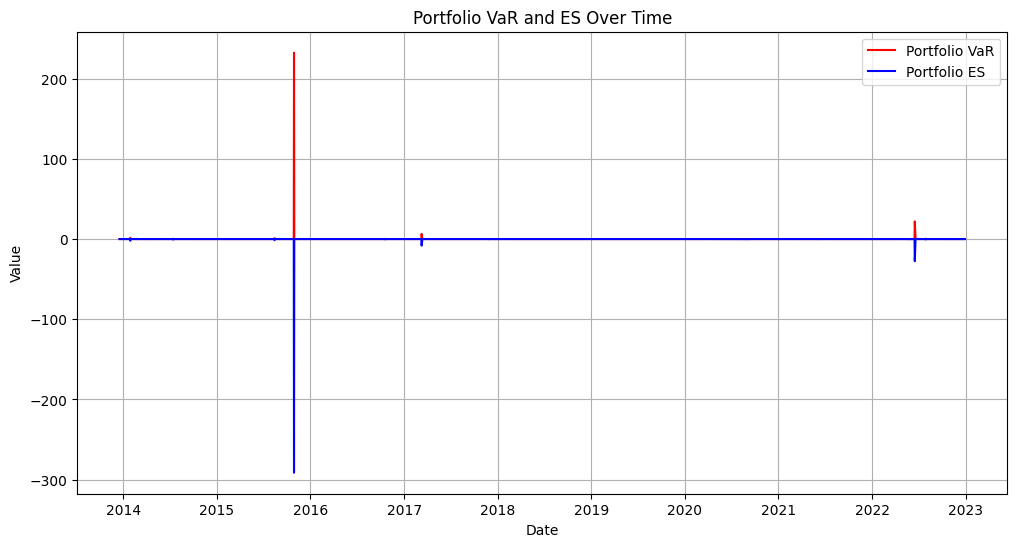

Date  Portfolio VaR  Portfolio ES
0    2013-12-17       0.013144     -0.016483
1    2013-12-18       0.010738     -0.013466
2    2013-12-19       0.015780     -0.019788
3    2013-12-20       0.016412     -0.020581
4    2013-12-23       0.016502     -0.020695
...         ...            ...           ...
2300 2022-12-23       0.032583     -0.040860
2301 2022-12-27       0.017546     -0.022003
2302 2022-12-28       0.018405     -0.023080
2303 2022-12-29       0.017915     -0.022466
2304 2022-12-30       0.018186     -0.022807

[2305 rows x 3 columns]

In [235]:
# main function to run the analysis
def main_analysis(time_window_size):
    # Initialize lists to store results
    portfolio_VaR_list = []
    portfolio_ES_list = []
    dates = []

    # Iterate through the dataset with a rolling time window
    for i in range(time_window_size, len(main_df)):
        # Extract the rolling time window
        window = main_df.iloc[i - time_window_size:i]
        current_date = main_df.iloc[i]['Date']
        
        # Calculate the returns for each asset in the window
        returns = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()

        # Define the weights for the portfolio
        weights = np.array([0.4, 0.3, 0.15, 0.15])

        # Calculate the covariance matrix
        cov_matrix = covariance_matrix(returns)

        # Calculate the portfolio VaR and ES
        VaR, ES = portfolio_VaR_ES(weights, cov_matrix)

        # Append results
        portfolio_VaR_list.append(VaR)
        portfolio_ES_list.append(ES)
        dates.append(current_date)

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Date': dates,
        'Portfolio VaR': portfolio_VaR_list,
        'Portfolio ES': portfolio_ES_list
    })

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Date'], results_df['Portfolio VaR'], label='Portfolio VaR', color='red')
    plt.plot(results_df['Date'], results_df['Portfolio ES'], label='Portfolio ES', color='blue')
    plt.title('Portfolio VaR and ES Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

    return results_df

time_window_size = 500

main_analysis(time_window_size)

In [241]:
# show only the column names and the first 3 rows of the main dataframe
print(main_df.columns)
print(main_df.head(3))

Index(['Date', 'S&P500_Closing', 'Dax40_Closing', 'Nikkei_Closing',
       'U_S&P500_Returns', 'U_Dax40_Returns', 'U_Nikkei_Returns',
       'U_S&P500_Loss', 'U_Dax40_Loss', 'U_Nikkei_Loss', 'C_S&P500_Returns',
       'C_Dax40_Returns', 'C_Nikkei_Returns', 'C_S&P500_Loss', 'C_Dax40_Loss',
       'C_Nikkei_Loss', 'USD/EUR', 'JPY/EUR', 'TIME PERIOD',
       'Yield curve spot rate, 10-year maturity - Government bond',
       'Interest_Bond', 'Interest_Bond_Profit', 'Interest_Bond_Loss',
       'Interest_Bond_daily_rate', 'SP500_Investment', 'DAX40_Investment',
       'NIKKEI_Investment', 'EU_BOND_Investment', 'SP500_Daily_Loss',
       'DAX40_Daily_Loss', 'NIKKEI_Daily_Loss', 'EU_BOND_Daily_Loss',
       'Portfolio_Value_EUR', 'Portfolio_Change_EUR', 'Portfolio_loss',
       'corrected_value_SP500', 'corrected_value_DAX40',
       'corrected_value_NIKKEI', 'corrected_value_EU_BOND', 'C_DAX40_Returns',
       'C_NIKKEI_Returns', 'C_EU_BOND_Returns'],
      dtype='object')
        Date  S&P

# Backtesting VaR and ES

In this section, we perform backtesting on the calculated Value at Risk (VaR) and Expected Shortfall (ES) measures. Backtesting helps assess the accuracy and reliability of the risk models.

We will:
1.  **Calculate Violations:** Identify the days where the actual portfolio loss exceeded the predicted VaR.
2.  **Compare Actual vs. Expected Violations (VaR):** Group violations by year and compare the observed number of violations against the number expected based on the confidence level (alpha).
3.  **Compare Actual Shortfall vs. Predicted ES (ES):** For the days a violation occurred, compare the average actual loss (shortfall) against the predicted ES, grouped by year.
4.  **Visualize Violations:** Plot the occurrences of violations over time to visually inspect for clustering or patterns.

In [242]:
def calculate_violations(actual_losses, var_predictions):
    """Checks for VaR violations."""
    return actual_losses > var_predictions

def backtest_var(violations, alpha, dates):
    """Compares actual vs. expected VaR violations yearly."""
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date': # Ensure index is Date for grouping
         violations = violations.set_index(dates)
            
    violations_df = pd.DataFrame({'Violations': violations, 'Year': violations.index.year})
    yearly_violations = violations_df.groupby('Year')['Violations'].sum()
    yearly_counts = violations_df.groupby('Year')['Violations'].count()
    
    expected_violations = yearly_counts * (1 - alpha)
    
    summary = pd.DataFrame({
        'Actual Violations': yearly_violations,
        'Expected Violations': expected_violations,
        'Total Observations': yearly_counts
    })
    return summary

def backtest_es(actual_losses, violations, es_predictions, dates):
    """Compares actual average shortfall vs. predicted ES yearly."""
    # Ensure inputs are pandas Series with Date index
    if not isinstance(actual_losses, pd.Series):
        actual_losses = pd.Series(actual_losses, index=dates)
    elif actual_losses.index.name != 'Date':
        actual_losses = actual_losses.set_index(dates)
        
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date':
        violations = violations.set_index(dates)
        
    if not isinstance(es_predictions, pd.Series):
        es_predictions = pd.Series(es_predictions, index=dates)
    elif es_predictions.index.name != 'Date':
        es_predictions = es_predictions.set_index(dates)

    results_df = pd.DataFrame({
        'Actual_Loss': actual_losses,
        'Violation': violations,
        'Predicted_ES': es_predictions,
        'Year': actual_losses.index.year
    })
    
    # Filter for violations
    violation_data = results_df[results_df['Violation']]
    
    # Calculate yearly averages
    yearly_avg_actual_shortfall = violation_data.groupby('Year')['Actual_Loss'].mean()
    yearly_avg_predicted_es = violation_data.groupby('Year')['Predicted_ES'].mean()
    yearly_violation_count = violation_data.groupby('Year').size()

    summary = pd.DataFrame({
        'Avg Actual Shortfall': yearly_avg_actual_shortfall,
        'Avg Predicted ES': yearly_avg_predicted_es,
        'Violation Count': yearly_violation_count
    })
    return summary

def plot_violations(violations, dates, title):
    """Plots VaR violations over time."""
    plt.figure(figsize=(15, 4))
    plt.plot(dates, violations, 'ro', markersize=4, alpha=0.7, label='Violation')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Violation (1=Yes, 0=No)')
    plt.yticks([0, 1])
    plt.grid(axis='y', linestyle='--')
    plt.show()

def run_backtesting(main_df, var_results_df, es_results_df):
    """Runs the backtesting process for VaR and ES models."""
    # Align main_df with var/es results (which start after the initial window)
    backtest_dates = var_results_df['Date']
    backtest_data = main_df[main_df['Date'].isin(backtest_dates)].set_index('Date')
    actual_losses = backtest_data['Portfolio_loss']

    # Confidence levels used
    alphas = [0.95, 0.99]
    alpha_indices = {0.95: 0, 0.99: 1} # Index mapping for results arrays

    # Iterate through models (columns in var_results_df/es_results_df)
    var_model_cols = [col for col in var_results_df.columns if col != 'Date']
    es_model_cols = [col for col in es_results_df.columns if col != 'Date']

    for i, model_name in enumerate(var_model_cols):
        print(f"\n--- Backtesting for Model: {model_name} ---")
        
        # Extract predictions for this model
        # Need to handle the fact that predictions are stored as arrays [pred_95, pred_99]
        var_preds_list = var_results_df[model_name].tolist()
        # Ensure alignment between var and es model columns
        if i < len(es_model_cols):
            es_preds_list = es_results_df[es_model_cols[i]].tolist()
        else:
            print(f"  Warning: No matching ES column found for {model_name}. Skipping ES backtest.")
            es_preds_list = None
        
        for alpha in alphas:
            alpha_idx = alpha_indices[alpha]
            print(f"\nConfidence Level: {alpha*100}%")
            
            # Extract predictions for the specific alpha
            # Handle potential errors if data isn't as expected (e.g., not a list/array)
            try:
                var_predictions = pd.Series([p[alpha_idx] for p in var_preds_list], index=backtest_dates)
                if es_preds_list:
                    es_predictions = pd.Series([p[alpha_idx] for p in es_preds_list], index=backtest_dates)
                else:
                    es_predictions = None
            except (TypeError, IndexError) as e:
                print(f"  Error extracting predictions for alpha={alpha}: {e}. Skipping.")
                continue
                
            # 1. Calculate Violations
            violations = calculate_violations(actual_losses, var_predictions)
            
            # 2. Backtest VaR
            var_summary = backtest_var(violations, alpha, backtest_dates)
            print("\nVaR Backtest Summary (Yearly):")
            display(var_summary)
            
            # 3. Backtest ES
            if es_predictions is not None:
                es_summary = backtest_es(actual_losses, violations, es_predictions, backtest_dates)
                print("\nES Backtest Summary (Yearly):")
                display(es_summary)
            
            # 4. Plot Violations
            plot_violations(violations, backtest_dates, f'VaR Violations for {model_name} (alpha={alpha})')


--- Backtesting for Model: VaR Normal ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


Actual Violations  Expected Violations  Total Observations
Year                                                            
2013                  0             0.450000                   9
2014                 28            12.750000                 255
2015                 39            12.700000                 254
2016                  9            12.850000                 257
2017                  3            12.750000                 255
2018                 30            12.650000                 253
2019                 16            12.650000                 253
2020                 24            12.750000                 255
2021                  4            12.850000                 257


ES Backtest Summary (Yearly):


Avg Actual Shortfall  Avg Predicted ES  Violation Count
Year                                                         
2014         127474.407200     111767.637767               28
2015         225762.168766     168969.121485               39
2016         245764.980182     240621.060542                9
2017         220400.343617     229231.334456                3
2018         202672.170657     168957.476526               30
2019         231804.299531     195423.033116               16
2020         500355.791430     285335.866458               24
2021         388888.445135     377548.697478                4

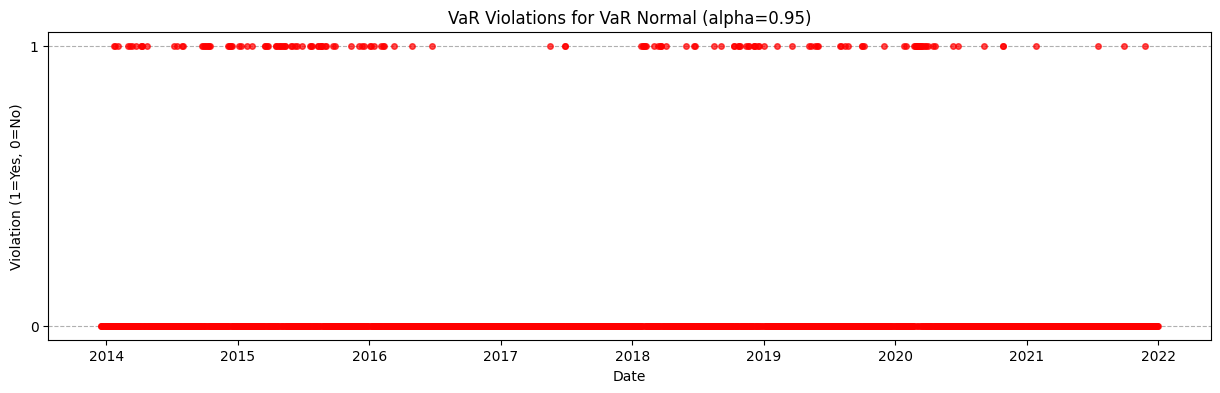


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


Actual Violations  Expected Violations  Total Observations
Year                                                            
2013                  0             0.090000                   9
2014                 10             2.550000                 255
2015                 24             2.540000                 254
2016                  3             2.570000                 257
2017                  0             2.550000                 255
2018                 15             2.530000                 253
2019                  8             2.530000                 253
2020                 15             2.550000                 255
2021                  1             2.570000                 257


ES Backtest Summary (Yearly):


Avg Actual Shortfall  Avg Predicted ES  Violation Count
Year                                                         
2014         163809.679720     142557.075727               10
2015         269131.467358     219035.041595               24
2016         309092.413225     310446.981960                3
2018         248676.621431     219674.530797               15
2019         273539.484965     250898.011460                8
2020         612483.145870     349191.650221               15
2021         575601.041257     490903.376876                1

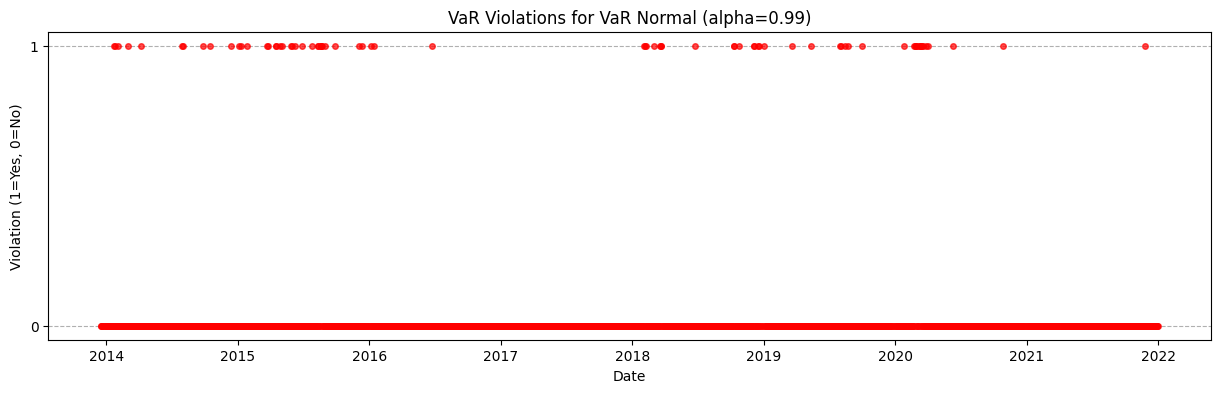


--- Backtesting for Model: VaR T3 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


Actual Violations  Expected Violations  Total Observations
Year                                                            
2013                  0             0.450000                   9
2014                 38            12.750000                 255
2015                 47            12.700000                 254
2016                 15            12.850000                 257
2017                 10            12.750000                 255
2018                 34            12.650000                 253
2019                 22            12.650000                 253
2020                 29            12.750000                 255
2021                 10            12.850000                 257


ES Backtest Summary (Yearly):


Avg Actual Shortfall  Avg Predicted ES  Violation Count
Year                                                         
2014         114189.456010     121541.755054               38
2015         210029.107433     186313.350633               47
2016         217712.436703     264131.938142               15
2017         166124.681649     230476.443738               10
2018         192421.406001     183427.581976               34
2019         203754.879000     210649.600191               22
2020         456403.407772     317179.345822               29
2021         320163.860728     411187.313445               10

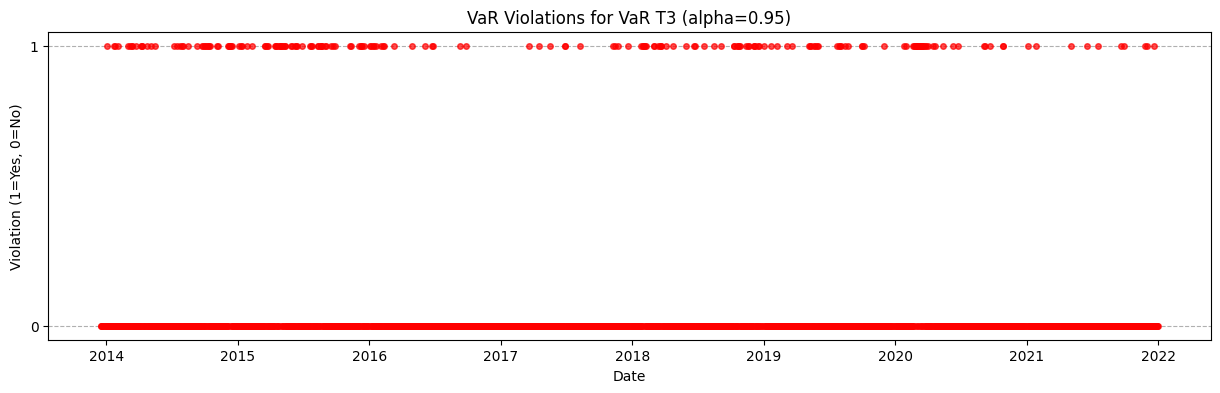


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


Actual Violations  Expected Violations  Total Observations
Year                                                            
2013                  0             0.090000                   9
2014                  7             2.550000                 255
2015                 17             2.540000                 254
2016                  1             2.570000                 257
2017                  0             2.550000                 255
2018                  9             2.530000                 253
2019                  5             2.530000                 253
2020                 13             2.550000                 255
2021                  1             2.570000                 257


ES Backtest Summary (Yearly):


Avg Actual Shortfall  Avg Predicted ES  Violation Count
Year                                                         
2014         179775.777259     219689.885288                7
2015         297575.746271     337575.399306               17
2016         351547.269932     457831.697688                1
2018         278426.553697     329957.215092                9
2019         297005.549830     381554.384084                5
2020         641228.124603     505164.674579               13
2021         575601.041257     748608.598544                1

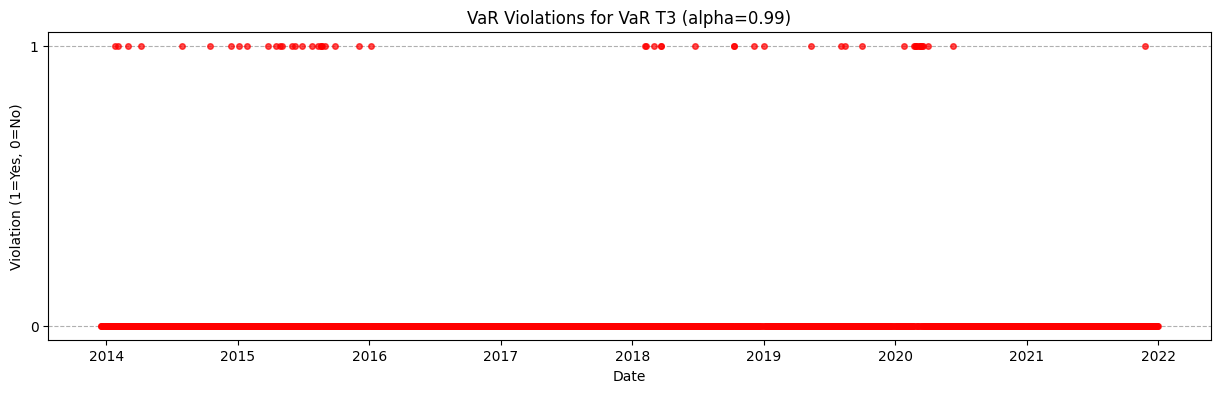


--- Backtesting for Model: VaR T4 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


Actual Violations  Expected Violations  Total Observations
Year                                                            
2013                  0             0.450000                   9
2014                 29            12.750000                 255
2015                 43            12.700000                 254
2016                 12            12.850000                 257
2017                  6            12.750000                 255
2018                 31            12.650000                 253
2019                 16            12.650000                 253
2020                 28            12.750000                 255
2021                  7            12.850000                 257


ES Backtest Summary (Yearly):


Avg Actual Shortfall  Avg Predicted ES  Violation Count
Year                                                         
2014         125831.123347     123015.472574               29
2015         218958.583471     189463.016559               43
2016         228935.696250     264442.475631               12
2017         189640.033713     244477.176118                6
2018         200130.746744     185715.977426               31
2019         231804.299531     214744.393933               16
2020         464847.993359     320046.944232               28
2021         343431.308700     415965.844953                7

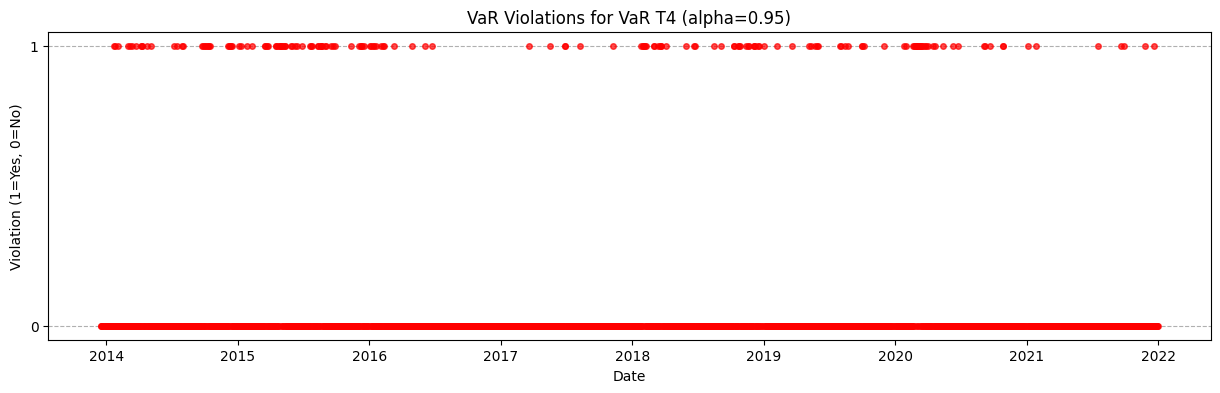


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


Actual Violations  Expected Violations  Total Observations
Year                                                            
2013                  0             0.090000                   9
2014                  7             2.550000                 255
2015                 16             2.540000                 254
2016                  1             2.570000                 257
2017                  0             2.550000                 255
2018                  8             2.530000                 253
2019                  5             2.530000                 253
2020                 13             2.550000                 255
2021                  1             2.570000                 257


ES Backtest Summary (Yearly):


Avg Actual Shortfall  Avg Predicted ES  Violation Count
Year                                                         
2014         179775.777259     200254.157823                7
2015         299610.721736     303544.917253               16
2016         351547.269932     417705.581257                1
2018         286383.111767     300882.042995                8
2019         297005.549830     348209.185823                5
2020         641228.124603     461055.483055               13
2021         575601.041257     682832.715535                1

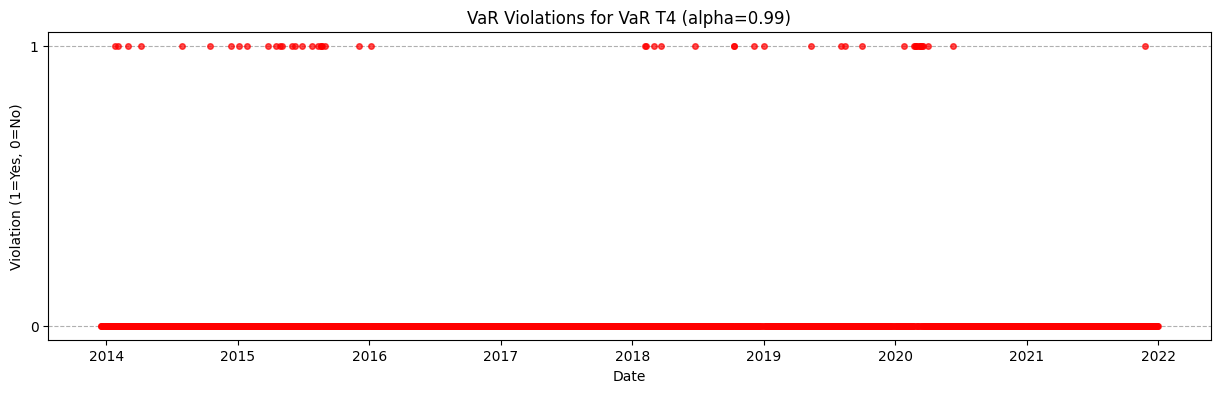


--- Backtesting for Model: VaR T5 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


Actual Violations  Expected Violations  Total Observations
Year                                                            
2013                  0             0.450000                   9
2014                 28            12.750000                 255
2015                 41            12.700000                 254
2016                  9            12.850000                 257
2017                  3            12.750000                 255
2018                 31            12.650000                 253
2019                 16            12.650000                 253
2020                 27            12.750000                 255
2021                  5            12.850000                 257


ES Backtest Summary (Yearly):


Avg Actual Shortfall  Avg Predicted ES  Violation Count
Year                                                         
2014         127474.407200     121630.688544               28
2015         221947.393472     184963.671038               41
2016         245764.980182     261394.268796                9
2017         220400.343617     248998.270383                3
2018         200130.746744     183533.792518               31
2019         231804.299531     212249.875886               16
2020         472195.475551     313766.849044               27
2021         369748.481860     412301.686231                5

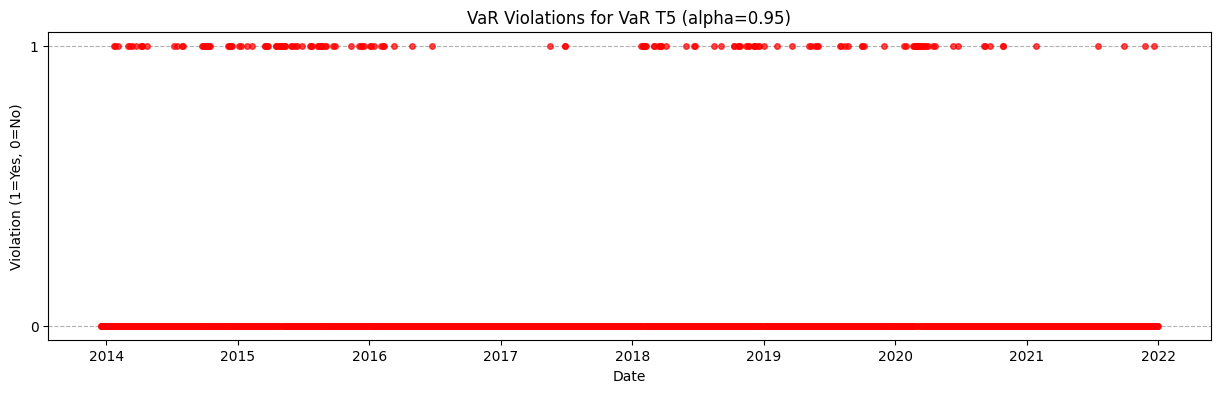


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


Actual Violations  Expected Violations  Total Observations
Year                                                            
2013                  0             0.090000                   9
2014                  7             2.550000                 255
2015                 17             2.540000                 254
2016                  1             2.570000                 257
2017                  0             2.550000                 255
2018                  9             2.530000                 253
2019                  5             2.530000                 253
2020                 13             2.550000                 255
2021                  1             2.570000                 257


ES Backtest Summary (Yearly):


Avg Actual Shortfall  Avg Predicted ES  Violation Count
Year                                                         
2014         179775.777259     186844.259356                7
2015         297575.746271     287045.004711               17
2016         351547.269932     390020.116529                1
2018         278426.553697     280866.522900                9
2019         297005.549830     325202.291751                5
2020         641228.124603     430621.850929               13
2021         575601.041257     637449.906260                1

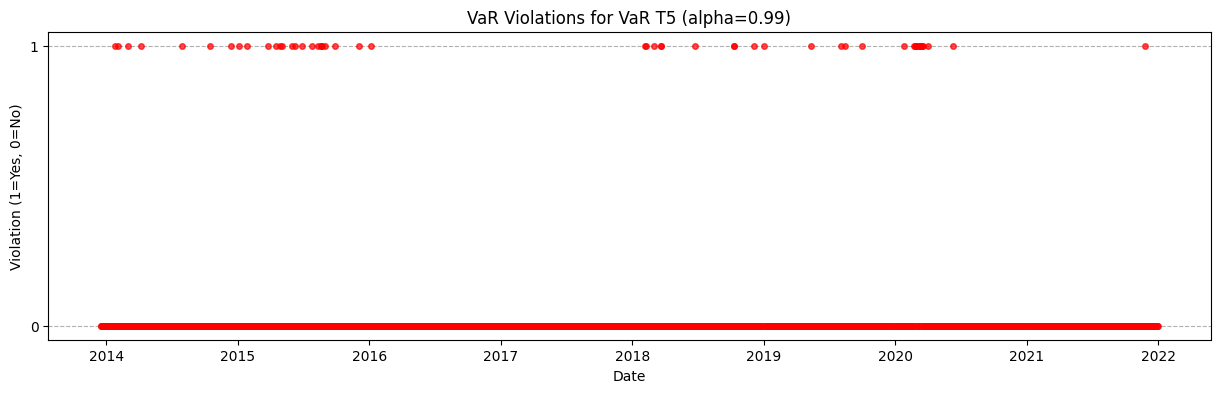


--- Backtesting for Model: VaR T6 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


Actual Violations  Expected Violations  Total Observations
Year                                                            
2013                  0             0.450000                   9
2014                 28            12.750000                 255
2015                 41            12.700000                 254
2016                  9            12.850000                 257
2017                  3            12.750000                 255
2018                 30            12.650000                 253
2019                 16            12.650000                 253
2020                 27            12.750000                 255
2021                  4            12.850000                 257


ES Backtest Summary (Yearly):


Avg Actual Shortfall  Avg Predicted ES  Violation Count
Year                                                         
2014         127474.407200     120208.413898               28
2015         221947.393472     182795.662088               41
2016         245764.980182     258398.724305                9
2017         220400.343617     246147.832680                3
2018         202672.170657     181565.240693               30
2019         231804.299531     209823.406390               16
2020         472195.475551     310190.169988               27
2021         388888.445135     405590.514099                4

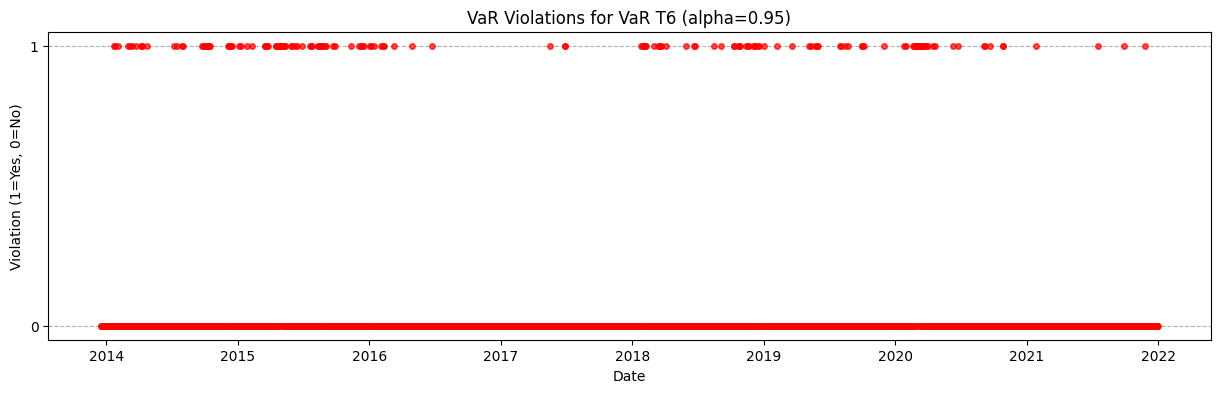


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


Actual Violations  Expected Violations  Total Observations
Year                                                            
2013                  0             0.090000                   9
2014                  7             2.550000                 255
2015                 18             2.540000                 254
2016                  1             2.570000                 257
2017                  0             2.550000                 255
2018                 10             2.530000                 253
2019                  5             2.530000                 253
2020                 14             2.550000                 255
2021                  1             2.570000                 257


ES Backtest Summary (Yearly):


Avg Actual Shortfall  Avg Predicted ES  Violation Count
Year                                                         
2014         179775.777259     178207.742216                7
2015         293488.314354     274408.631364               18
2016         351547.269932     372189.557165                1
2018         270724.698869     267132.585910               10
2019         297005.549830     310384.921171                5
2020         629342.984889     424621.689973               14
2021         575601.041257     608221.541020                1

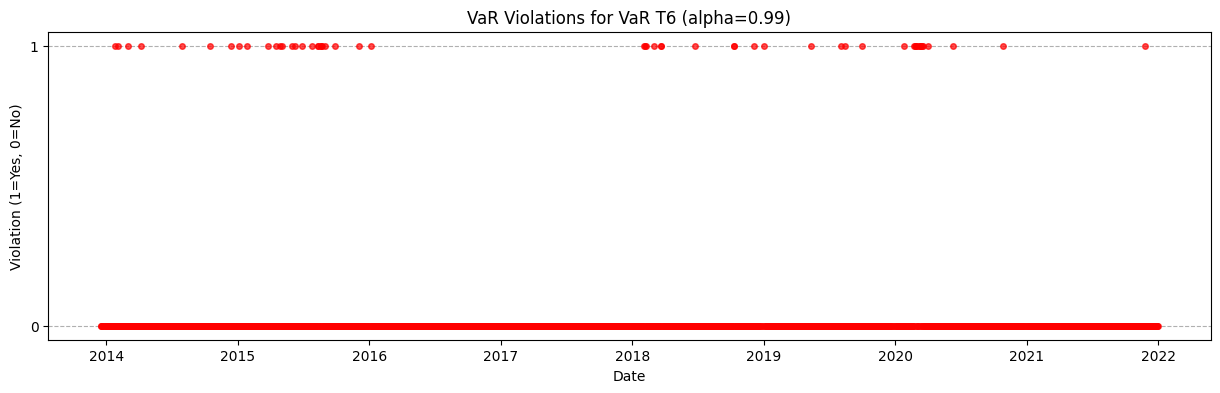


--- Backtesting for Model: VaR Historical ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


Actual Violations  Expected Violations  Total Observations
Year                                                            
2013                  0             0.450000                   9
2014                 27            12.750000                 255
2015                 39            12.700000                 254
2016                  7            12.850000                 257
2017                  3            12.750000                 255
2018                 27            12.650000                 253
2019                 13            12.650000                 253
2020                 27            12.750000                 255
2021                  5            12.850000                 257


ES Backtest Summary (Yearly):


Avg Actual Shortfall  Avg Predicted ES  Violation Count
Year                                                         
2014         128777.469881     125501.572969               27
2015         227072.609816     196418.111874               39
2016         257968.714712     282523.749871                7
2017         220400.343617     275210.049518                3
2018         209631.041495     195629.120656               27
2019         244184.577059     236283.804872               13
2020         476939.638751     392817.016182               27
2021         369748.481860     506518.996898                5

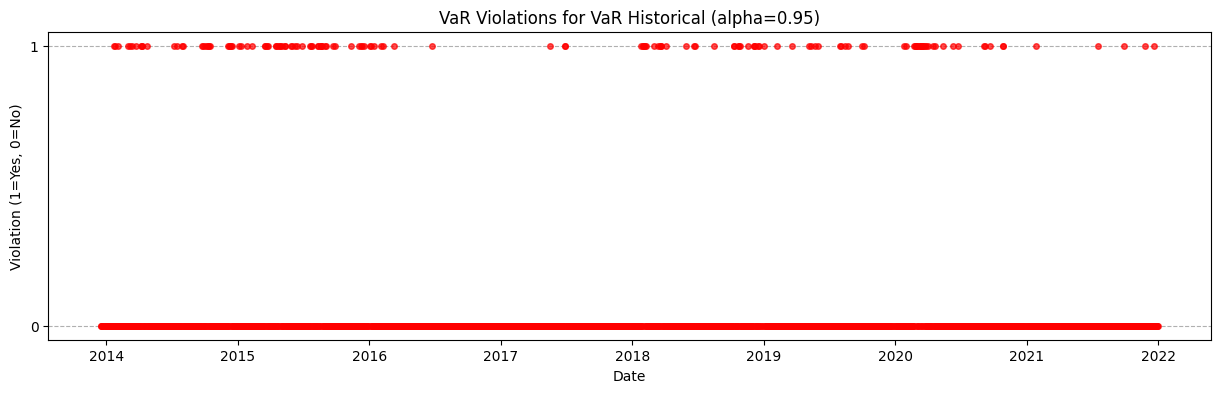


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


Actual Violations  Expected Violations  Total Observations
Year                                                            
2013                  0             0.090000                   9
2014                  7             2.550000                 255
2015                 14             2.540000                 254
2016                  1             2.570000                 257
2017                  0             2.550000                 255
2018                  8             2.530000                 253
2019                  5             2.530000                 253
2020                 10             2.550000                 255
2021                  0             2.570000                 257


ES Backtest Summary (Yearly):


Avg Actual Shortfall  Avg Predicted ES  Violation Count
Year                                                         
2014         177716.101099     171450.129245                7
2015         312159.951928     275191.404353               14
2016         351547.269932     428332.323854                1
2018         286383.111767     270660.091418                8
2019         297005.549830     322629.692461                5
2020         722801.810819     573681.436089               10

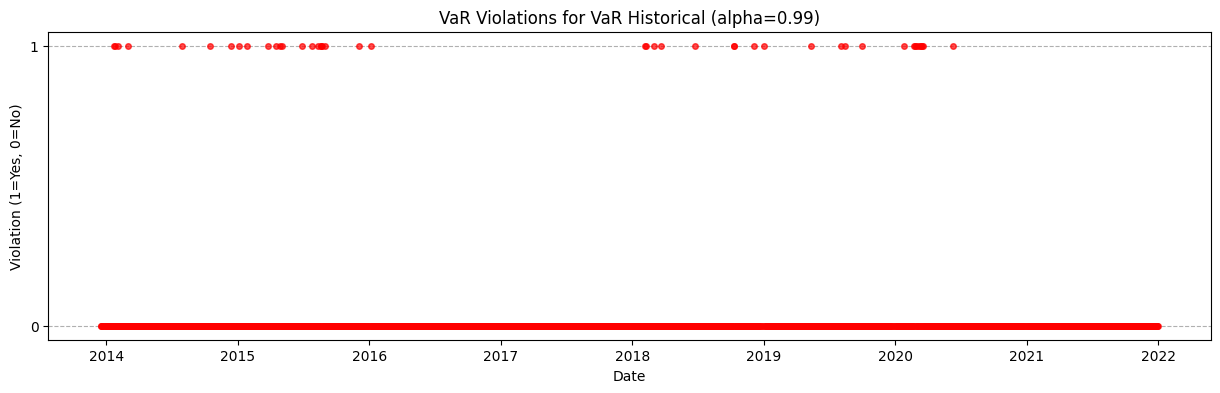

In [243]:
# Call the backtesting function with the required dataframes
run_backtesting(main_df, var_results_df, es_results_df)

### Backtesting Interpretation

Review the tables and plots above:

*   **VaR Backtest:** Compare 'Actual Violations' to 'Expected Violations' each year. Significant deviations might indicate issues with the VaR model's calibration. If actual violations consistently exceed expected, the model underestimates risk. If they are consistently lower, it might be too conservative.
*   **ES Backtest:** Compare 'Avg Actual Shortfall' to 'Avg Predicted ES'. If the actual average shortfall during violations is consistently higher than the predicted ES, the model underestimates the severity of tail losses.
*   **Violation Plots:** Look for patterns. Ideally, violations should be randomly distributed. Clustering of violations suggests the model fails to adapt quickly to changing market volatility (violation dependence).


Start Date   End Date  Mean S&P500 Returns
0 2012-01-04 2013-12-17             0.000568
1 2012-01-05 2013-12-18             0.000612
2 2012-01-06 2013-12-19             0.000584
3 2012-01-09 2013-12-20             0.000587
4 2012-01-10 2013-12-23             0.000596

Start Date   End Date  Mean DAX40 Returns
0 2012-01-04 2013-12-17            0.000848
1 2012-01-05 2013-12-18            0.000868
2 2012-01-06 2013-12-19            0.000907
3 2012-01-09 2013-12-20            0.000933
4 2012-01-10 2013-12-23            0.000965

Start Date   End Date  Mean Nikkei Returns
0 2012-01-04 2013-12-17             0.000547
1 2012-01-05 2013-12-18             0.000567
2 2012-01-06 2013-12-19             0.000612
3 2012-01-09 2013-12-20             0.000621
4 2012-01-10 2013-12-23             0.000621

Start Date   End Date  Mean EU Bond Returns
0 2012-01-04 2013-12-17              0.000137
1 2012-01-05 2013-12-18              0.000137
2 2012-01-06 2013-12-19              0.000137
3 2012-01-09 2013-12-20              0.000137
4 2012-01-10 2013-12-23              0.000137

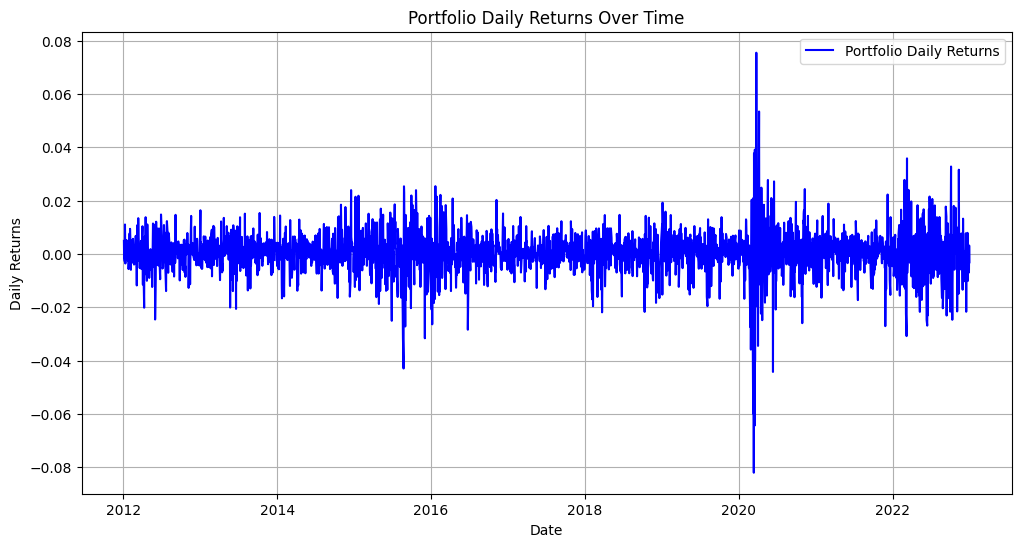

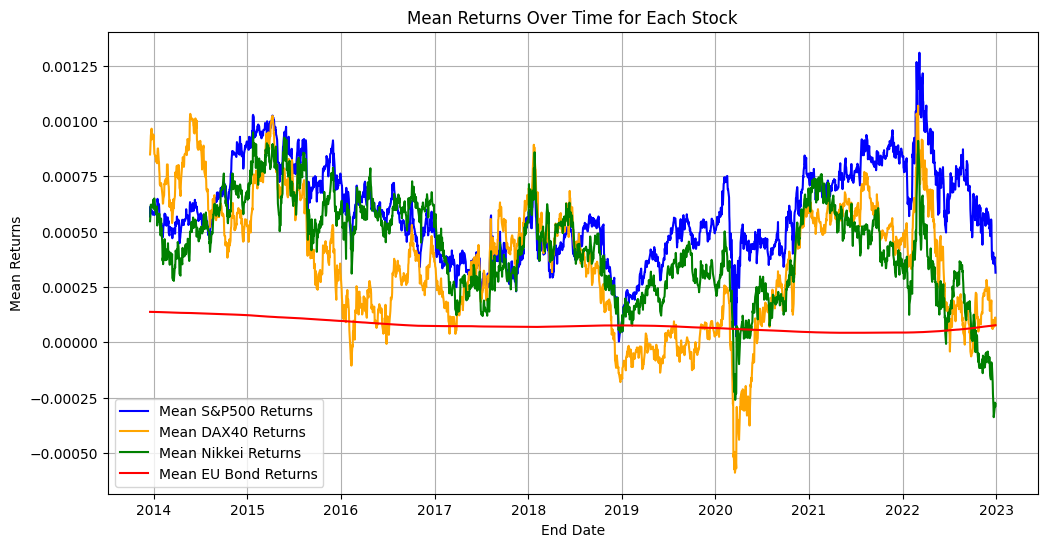

In [256]:
# checking assumption on taking mean = 0 
# Calculate portfolio daily returns
main_df['Portfolio_Daily_Returns'] = (
    weights[0] * main_df['C_S&P500_Returns'] +
    weights[1] * main_df['C_Dax40_Returns'] +
    weights[2] * main_df['C_Nikkei_Returns'] +
    weights[3] * main_df['Interest_Bond_daily_rate']
)

# make a graph of the portfolio daily returns
plt.figure(figsize=(12, 6))
plt.plot(main_df['Date'], main_df['Portfolio_Daily_Returns'], label='Portfolio Daily Returns', color='blue')
plt.title('Portfolio Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid()
#plt.show()

# Calculate the mean of the returns for each stock over a subset of the data defined on the time range
# Define the sample size
sample_size = 500

# Initialize variables to store the mean returns for each stock for each time window
mean_sp500_returns_list = []
mean_dax40_returns_list = []
mean_nikkei_returns_list = []
mean_eu_bond_returns_list = []

# Loop through the data with a fixed sample size
for i in range(sample_size, len(main_df)):
    time_range_start = main_df['Date'].iloc[i - sample_size]
    time_range_end = main_df['Date'].iloc[i]
    time_range_df = main_df[(main_df['Date'] >= time_range_start) & (main_df['Date'] <= time_range_end)]
    
    # Calculate mean returns for each stock
    mean_sp500_returns = time_range_df['C_S&P500_Returns'].mean()
    mean_dax40_returns = time_range_df['C_Dax40_Returns'].mean()
    mean_nikkei_returns = time_range_df['C_Nikkei_Returns'].mean()
    mean_eu_bond_returns = time_range_df['Interest_Bond_daily_rate'].mean()
    
    # Append the results to the respective lists
    mean_sp500_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean S&P500 Returns': mean_sp500_returns
    })
    mean_dax40_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean DAX40 Returns': mean_dax40_returns
    })
    mean_nikkei_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean Nikkei Returns': mean_nikkei_returns
    })
    mean_eu_bond_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean EU Bond Returns': mean_eu_bond_returns
    })

# Convert the results to DataFrames for easier analysis
mean_sp500_returns_df = pd.DataFrame(mean_sp500_returns_list)
mean_dax40_returns_df = pd.DataFrame(mean_dax40_returns_list)
mean_nikkei_returns_df = pd.DataFrame(mean_nikkei_returns_list)
mean_eu_bond_returns_df = pd.DataFrame(mean_eu_bond_returns_list)

# Display the results
display(mean_sp500_returns_df.head())
display(mean_dax40_returns_df.head())
display(mean_nikkei_returns_df.head())
display(mean_eu_bond_returns_df.head())

# Plot the mean returns for each stock over time
plt.figure(figsize=(12, 6))
plt.plot(mean_sp500_returns_df['End Date'], mean_sp500_returns_df['Mean S&P500 Returns'], label='Mean S&P500 Returns', color='blue')
plt.plot(mean_dax40_returns_df['End Date'], mean_dax40_returns_df['Mean DAX40 Returns'], label='Mean DAX40 Returns', color='orange')
plt.plot(mean_nikkei_returns_df['End Date'], mean_nikkei_returns_df['Mean Nikkei Returns'], label='Mean Nikkei Returns', color='green')
plt.plot(mean_eu_bond_returns_df['End Date'], mean_eu_bond_returns_df['Mean EU Bond Returns'], label='Mean EU Bond Returns', color='red')
plt.title('Mean Returns Over Time for Each Stock')
plt.xlabel('End Date')
plt.ylabel('Mean Returns')
plt.legend()
plt.grid()
plt.show()